### 데이터 전처리

1. remove_null_columns(df), remove_single_value_columns(df) 함수 사용
2. failure disk 데이터들에 대해서, linear interpolate
3. 각 failure disk 별로 고장난 날짜 포함 10일에 대해서,timeseries clustering 하려고 함.
4. 처음 관측된 날짜와 fail이 일어난 날짜와의 차이가 9(10-1)보다 작으면, failure disk에서 제외시킴.
5. fail이 일어나기 이전 9일전 + fail이 일어난 날(총 10일) 데이터를 생성(=to_cluster_data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
import mglearn

In [3]:
data = pd.read_csv('../../ssd_data/combined_by_diskmodel/combined_MB1.csv',index_col=False)

# 데이터를 시간 순서대로 정렬 ('ds' 컬럼을 기준으로)
data = data.sort_values(by=['ds'])
data = data.drop_duplicates(subset=['disk_id', 'ds'])
data.reset_index(inplace=True)
del(data['index'])
del(data['level_0'])
data

disk_id        ds model  n_1  r_1    n_5  r_5   n_9      r_9  n_12  \
0          10005  20190101   MB1  NaN  NaN  100.0  0.0  99.0   4600.0  99.0   
1          39138  20190101   MB1  NaN  NaN  100.0  0.0  97.0  13256.0  99.0   
2           3918  20190101   MB1  NaN  NaN  100.0  0.0  97.0  13305.0  99.0   
3          39187  20190101   MB1  NaN  NaN  100.0  0.0  97.0  12934.0  99.0   
4          39189  20190101   MB1  NaN  NaN  100.0  0.0  97.0  12934.0  99.0   
...          ...       ...   ...  ...  ...    ...  ...   ...      ...   ...   
7132648    27627  20190630   MB1  NaN  NaN  100.0  0.0  96.0  17027.0  99.0   
7132649    27631  20190630   MB1  NaN  NaN  100.0  0.0  96.0  17027.0  99.0   
7132650    27676  20190630   MB1  NaN  NaN  100.0  0.0  96.0  18069.0  99.0   
7132651    27586  20190630   MB1  NaN  NaN  100.0  0.0  98.0   8476.0  99.0   
7132652     9975  20190630   MB1  NaN  NaN  100.0  0.0  96.0  17397.0  99.0   

         ...  r_244  n_245    r_245  n_175  r_175  n_232  r_232  label  n_211  \
0        ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
1        ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
2        ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
3        ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
4        ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
...      ...    ...    ...      ...    ...    ...    ...    ...    ...    ...   
7132648  ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
7132649  ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
7132650  ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
7132651  ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
7132652  ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   

         r_211  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
...        ...  
7132648    NaN  
7132649    NaN  
7132650    NaN  
7132651    NaN  
7132652    NaN  

[7132653 rows x 72 columns]

In [5]:
# null값이 있는 열을 제거하는 코드
def remove_null_columns(df):
    # null인 컬럼을 확인하고, 모든 값이 null인 컬럼을 찾습니다.
    null_columns = df.columns[df.isnull().all()]
    
    # 모든 값이 null인 컬럼을 DataFrame에서 제거합니다.
    df = df.drop(null_columns, axis=1)
    
    return df
# 하나의 unique한 값으로만 이루어진 컬럼을 제거하는 코드
def remove_single_value_columns(df):
    single_value_cols = []
    for col in df.columns:
        unique_values = df[col].nunique()
        if unique_values == 1:
            single_value_cols.append(col)

    df_filtered = df.drop(single_value_cols, axis=1)
    return df_filtered


In [6]:
data = remove_null_columns(data)
data = remove_single_value_columns(data)

failed된 disk_id중에서 첫 관측에서 마지막 관측의 결측치 채우기<br>
interpolate-linear

In [7]:
selected_disk_ids = data[data['label']==1]['disk_id'].unique()

dfs_to_concat = []  # 추가할 데이터프레임들을 저장할 리스트

for disk_id in selected_disk_ids:
    disk_data = data[data['disk_id'] == disk_id].copy()
    disk_data['ds'] = pd.to_datetime(disk_data['ds'], format='%Y%m%d')
    disk_data = disk_data.sort_values(by='ds')
    disk_data = disk_data.set_index('ds', drop=True)
    all_dates = pd.date_range(start=disk_data.index.min(), end=disk_data.index.max(), freq='D')
    disk_data = disk_data.reindex(all_dates)
    disk_data = disk_data.interpolate(method='linear')
    dfs_to_concat.append(disk_data)

interpolated_data = pd.concat(dfs_to_concat)  # 데이터프레임들을 연결하여 새로운 데이터프레임 생성

interpolated_data = interpolated_data.reset_index()  # 인덱스 재설정
interpolated_data

index  disk_id    n_5  r_5   n_9      r_9  n_12  r_12  n_177  \
0     2019-01-01  17909.0   99.0  2.0  97.0  12819.0  99.0  19.0   97.0   
1     2019-01-02  17909.0   99.0  2.0  97.0  12843.0  99.0  19.0   97.0   
2     2019-01-03  17909.0   99.0  2.0  97.0  12867.0  99.0  19.0   97.0   
3     2019-01-04  17909.0   99.0  2.0  97.0  12891.0  99.0  19.0   97.0   
4     2019-01-05  17909.0   99.0  2.0  97.0  12915.0  99.0  19.0   97.0   
...          ...      ...    ...  ...   ...      ...   ...   ...    ...   
43895 2019-06-26   8599.0  100.0  0.0  96.0  17168.0  99.0  21.0   91.0   
43896 2019-06-27   8599.0  100.0  0.0  96.0  17192.0  99.0  21.0   91.0   
43897 2019-06-28   8599.0  100.0  0.0  96.0  17216.0  99.0  21.0   91.0   
43898 2019-06-29   8599.0   99.0  2.0  96.0  17240.0  99.0  21.0   91.0   
43899 2019-06-30   8599.0   99.0  2.0  96.0  17264.0  99.0  21.0   91.0   

       r_177  ...  r_194  n_195  r_195  n_199  r_199  n_241         r_241  \
0      155.0  ...   32.0  199.0    1.0  100.0    0.0   99.0  4.761304e+11   
1      155.0  ...   31.0  199.0    1.0  100.0    0.0   99.0  4.774871e+11   
2      156.0  ...   31.0  199.0    1.0  100.0    0.0   99.0  4.790559e+11   
3      156.0  ...   32.0  199.0    1.0  100.0    0.0   99.0  4.805626e+11   
4      157.0  ...   31.0  199.0    1.0  100.0    0.0   99.0  4.819720e+11   
...      ...  ...    ...    ...    ...    ...    ...    ...           ...   
43895  623.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201000e+12   
43896  623.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201312e+12   
43897  624.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  2.201585e+12   
43898  624.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201871e+12   
43899  624.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201928e+12   

       n_242         r_242  label  
0       99.0  3.422788e+11    1.0  
1       99.0  3.432220e+11    0.0  
2       99.0  3.467700e+11    0.0  
3       99.0  3.477830e+11    0.0  
4       99.0  3.512526e+11    0.0  
...      ...           ...    ...  
43895   99.0  8.356453e+11    0.0  
43896   99.0  8.362658e+11    0.0  
43897   99.0  8.371074e+11    0.0  
43898   99.0  8.379656e+11    0.0  
43899   99.0  8.381230e+11    1.0  

[43900 rows x 35 columns]

In [8]:
selected_disk_model_1 = interpolated_data['disk_id'].unique()

to_delete_id =[]
for disk_id in selected_disk_model_1:
    disk_data = interpolated_data[interpolated_data['disk_id'] == disk_id].copy()
    disk_data = disk_data.sort_values(by='index')
    disk_data.reset_index(inplace=True,drop=True)

    failed_index = disk_data[disk_data['label']==1]['index'].index.min()
    start_index = disk_data.index.min()

    if(failed_index - start_index) < 9:
        to_delete_id.append(disk_id)

# failed_disk_index에 해당하는 행들을 제거
data = interpolated_data[~interpolated_data['disk_id'].isin(to_delete_id)]
data

index  disk_id    n_5  r_5   n_9      r_9  n_12  r_12  n_177  \
1109  2019-01-01  43191.0  100.0  0.0  97.0  13760.0  99.0  22.0   97.0   
1110  2019-01-02  43191.0  100.0  0.0  97.0  13784.0  99.0  22.0   97.0   
1111  2019-01-03  43191.0  100.0  0.0  97.0  13808.0  99.0  22.0   97.0   
1112  2019-01-04  43191.0  100.0  0.0  97.0  13832.0  99.0  22.0   97.0   
1113  2019-01-05  43191.0  100.0  0.0  97.0  13856.0  99.0  22.0   97.0   
...          ...      ...    ...  ...   ...      ...   ...   ...    ...   
43895 2019-06-26   8599.0  100.0  0.0  96.0  17168.0  99.0  21.0   91.0   
43896 2019-06-27   8599.0  100.0  0.0  96.0  17192.0  99.0  21.0   91.0   
43897 2019-06-28   8599.0  100.0  0.0  96.0  17216.0  99.0  21.0   91.0   
43898 2019-06-29   8599.0   99.0  2.0  96.0  17240.0  99.0  21.0   91.0   
43899 2019-06-30   8599.0   99.0  2.0  96.0  17264.0  99.0  21.0   91.0   

       r_177  ...  r_194  n_195  r_195  n_199  r_199  n_241         r_241  \
1109   180.0  ...   30.0  200.0    0.0   99.0    8.0   99.0  5.307367e+11   
1110   181.0  ...   30.0  200.0    0.0   99.0    8.0   99.0  5.318034e+11   
1111   181.0  ...   30.0  200.0    0.0   99.0    8.0   99.0  5.327934e+11   
1112   182.0  ...   29.0  200.0    0.0   99.0    8.0   99.0  5.338197e+11   
1113   183.0  ...   32.0  200.0    0.0   99.0    8.0   99.0  5.349756e+11   
...      ...  ...    ...    ...    ...    ...    ...    ...           ...   
43895  623.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201000e+12   
43896  623.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201312e+12   
43897  624.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  2.201585e+12   
43898  624.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201871e+12   
43899  624.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201928e+12   

       n_242         r_242  label  
1109    99.0  5.859705e+11    0.0  
1110    99.0  5.889655e+11    0.0  
1111    99.0  5.918898e+11    0.0  
1112    99.0  5.947108e+11    0.0  
1113    99.0  5.975866e+11    0.0  
...      ...           ...    ...  
43895   99.0  8.356453e+11    0.0  
43896   99.0  8.362658e+11    0.0  
43897   99.0  8.371074e+11    0.0  
43898   99.0  8.379656e+11    0.0  
43899   99.0  8.381230e+11    1.0  

[41506 rows x 35 columns]

In [9]:
# 라벨이 1인 행을 필터링합니다.
selected_disk_model_1 = data[data['label'] == 1]

# 모델, disk_id, 그리고 날짜 순으로 정렬합니다.
selected_disk_model_1 = selected_disk_model_1.sort_values(by=['disk_id', 'index'])

# disk_id와 model 열만을 선택하여 새로운 데이터 프레임에 저장합니다.
selected_disk_model_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)

# 결과 데이터 프레임을 출력합니다.
selected_disk_model_1.shape

(244, 1)

In [10]:
to_cluster_data = pd.DataFrame()

for disk_id in selected_disk_model_1['disk_id'].unique():
    disk_data = data[data['disk_id'] == disk_id].copy()
    disk_data = disk_data.sort_values(by='index')
    disk_data.reset_index(inplace=True,drop=True)

    failed_index = disk_data[disk_data['label']==1]['index'].index.min()
    before_9day_index = failed_index - 9

    to_cluster = disk_data.iloc[before_9day_index:failed_index+1, :]
    to_cluster_data = pd.concat([to_cluster_data,to_cluster],axis=0)
    
to_cluster_data

index  disk_id   n_5  r_5   n_9      r_9  n_12  r_12  n_177  r_177  \
74 2019-03-16    470.0  99.0  4.0  96.0  16054.0  99.0  18.0   99.0    7.0   
75 2019-03-17    470.0  99.0  4.0  96.0  16078.0  99.0  18.0   99.0    7.0   
76 2019-03-18    470.0  99.0  4.0  96.0  16102.0  99.0  18.0   99.0    7.0   
77 2019-03-19    470.0  99.0  4.0  96.0  16126.0  99.0  18.0   99.0    7.0   
78 2019-03-20    470.0  99.0  4.0  96.0  16150.0  99.0  18.0   99.0    7.0   
..        ...      ...   ...  ...   ...      ...   ...   ...    ...    ...   
79 2019-03-21  44338.0  99.0  2.0  96.0  16176.0  99.0  21.0   99.0    6.0   
80 2019-03-22  44338.0  99.0  2.0  96.0  16200.0  99.0  21.0   99.0    6.0   
81 2019-03-23  44338.0  99.0  2.0  96.0  16224.0  99.0  21.0   99.0    6.0   
82 2019-03-24  44338.0  99.0  2.0  96.0  16248.0  99.0  21.0   99.0    6.0   
83 2019-03-25  44338.0  99.0  2.0  96.0  16272.0  99.0  21.0   99.0    6.0   

    ...  r_194  n_195  r_195  n_199  r_199  n_241         r_241  n_242  \
74  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
75  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
76  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
77  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
78  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
..  ...    ...    ...    ...    ...    ...    ...           ...    ...   
79  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
80  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
81  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
82  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
83  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   

           r_242  label  
74  8.743607e+09    0.0  
75  8.744597e+09    0.0  
76  8.745809e+09    0.0  
77  8.747037e+09    0.0  
78  8.748307e+09    0.0  
..           ...    ...  
79  8.778025e+09    0.0  
80  8.779657e+09    0.0  
81  8.781085e+09    0.0  
82  8.782419e+09    0.0  
83  8.783980e+09    1.0  

[2680 rows x 35 columns]

In [11]:
#10일씩 제대로 묶였는지 확인 => ok
to_cluster_data[to_cluster_data['disk_id']==470]

index  disk_id   n_5  r_5   n_9      r_9  n_12  r_12  n_177  r_177  \
74 2019-03-16    470.0  99.0  4.0  96.0  16054.0  99.0  18.0   99.0    7.0   
75 2019-03-17    470.0  99.0  4.0  96.0  16078.0  99.0  18.0   99.0    7.0   
76 2019-03-18    470.0  99.0  4.0  96.0  16102.0  99.0  18.0   99.0    7.0   
77 2019-03-19    470.0  99.0  4.0  96.0  16126.0  99.0  18.0   99.0    7.0   
78 2019-03-20    470.0  99.0  4.0  96.0  16150.0  99.0  18.0   99.0    7.0   
79 2019-03-21    470.0  99.0  4.0  96.0  16174.0  99.0  18.0   99.0    7.0   
80 2019-03-22    470.0  99.0  4.0  96.0  16198.0  99.0  18.0   99.0    7.0   
81 2019-03-23    470.0  99.0  4.0  96.0  16222.0  99.0  18.0   99.0    7.0   
82 2019-03-24    470.0  99.0  4.0  96.0  16246.0  99.0  18.0   99.0    7.0   
83 2019-03-25    470.0  99.0  4.0  96.0  16270.0  99.0  18.0   99.0    7.0   

    ...  r_194  n_195  r_195  n_199  r_199  n_241         r_241  n_242  \
74  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
75  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
76  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
77  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
78  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
79  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
80  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
81  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
82  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
83  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   

           r_242  label  
74  8.743607e+09    0.0  
75  8.744597e+09    0.0  
76  8.745809e+09    0.0  
77  8.747037e+09    0.0  
78  8.748307e+09    0.0  
79  8.749580e+09    0.0  
80  8.750794e+09    0.0  
81  8.751875e+09    0.0  
82  8.752874e+09    0.0  
83  8.754062e+09    1.0  

[10 rows x 35 columns]

### Euclidean_kmeans

In [54]:
#Scaling 과정
from sklearn.preprocessing import MinMaxScaler

# feature_data = to_cluster_data.sort_values(by=["disk_id", "index"]).drop(columns=['index','disk_id','label'])

# scaler = MinMaxScaler()
# sclaed_feature_data = scaler.fit_transform(feature_data)

# Assuming 'X_train' is the original DataFrame before scaling and its columns are to be preserved
#scaled_cluster_df = pd.DataFrame(sclaed_feature_data, columns=feature_data.columns, index=feature_data.index)
#to_cluster_df = pd.concat([to_cluster_data.sort_values(by=["disk_id", "index"])[['index','disk_id','label']],scaled_cluster_df], axis=1)

to_cluster = to_cluster_data.drop(columns=['index','label'])

grouped = to_cluster.groupby("disk_id").apply(np.array)

to_cluster = np.array(grouped.tolist())  # This is now a 3D array (n_samples, n_timestamps, n_features)
to_cluster = to_cluster[:, :, 1:]
to_cluster.shape

(268, 10, 32)

In [65]:
# Scale the data
scaler = TimeSeriesScalerMeanVariance()
data_scaled = scaler.fit_transform(to_cluster)

In [66]:
def calculate_scores(num_clusters, data_scaled):
    km_dtw = TimeSeriesKMeans(n_clusters=num_clusters, metric="euclidean")
    clusters = km_dtw.fit_predict(data_scaled)
    silhouette = silhouette_score(data_scaled.reshape(data_scaled.shape[0], -1), clusters)
    inertia = km_dtw.inertia_
    return silhouette, inertia

In [67]:
num_clusters_range = range(2, 11)
silhouette_scores = []
inertia_scores = []

for k in num_clusters_range:
    silhouette, inertia = calculate_scores(k, data_scaled)
    silhouette_scores.append(silhouette)
    inertia_scores.append(inertia)

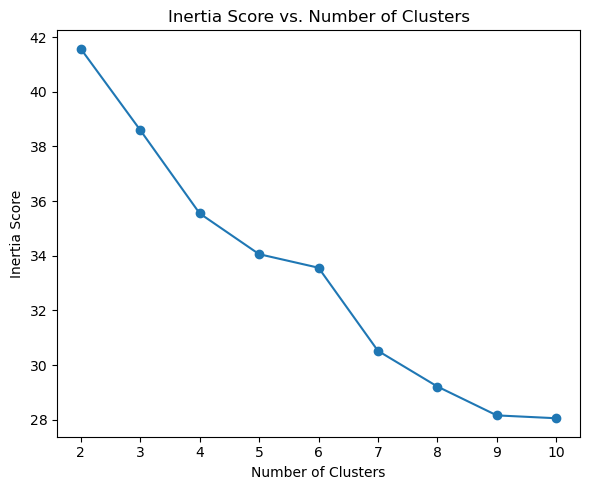

In [68]:
# Plot only the Inertia Score vs. Number of Clusters
plt.figure(figsize=(6, 5))
plt.plot(num_clusters_range, inertia_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Score")
plt.title("Inertia Score vs. Number of Clusters")
plt.tight_layout()
plt.show()

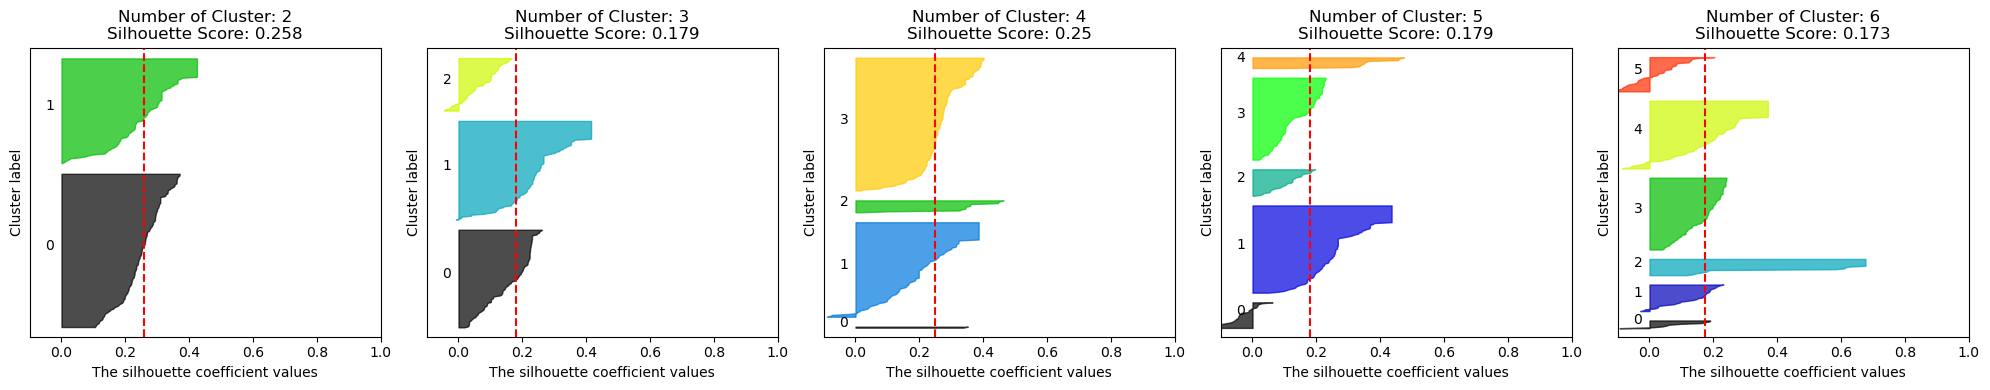

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score, silhouette_samples

# Assuming you have already scaled your time series data (data_scaled) using TimeSeriesScalerMeanVariance
def visualize_silhouette(cluster_lists, data_scaled):
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    # Flatten the 3-dimensional time series data into 2-dimensional array
    data_reshaped = data_scaled.reshape(data_scaled.shape[0], -1)

    for ind, n_cluster in enumerate(cluster_lists):
        km_dtw = TimeSeriesKMeans(n_clusters=n_cluster, metric="euclidean", verbose=False)
        clusters = km_dtw.fit_predict(data_scaled)

        # Calculate the silhouette score on the reshaped data
        silhouette_avg = silhouette_score(data_reshaped, clusters)

        sample_silhouette_values = silhouette_samples(data_reshaped, clusters)
        y_lower = 10

        axs[ind].set_title('Number of Cluster: ' + str(n_cluster) + '\n'
                          'Silhouette Score: ' + str(round(silhouette_avg, 3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(data_scaled) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sample_silhouette_values[clusters == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=silhouette_avg, color="red", linestyle="--")

# Example usage with your data_scaled (assuming it's a NumPy array of time series data)
visualize_silhouette(range(2, 7), data_scaled)
plt.tight_layout()
plt.show()

In [81]:
# Choose the number of clusters (k) you want
k = 2

# Run the TimeSeriesKMeans algorithm with DTW distance
km_dtw = TimeSeriesKMeans(n_clusters=k, metric="euclidean")
clusters = km_dtw.fit_predict(data_scaled)

In [82]:
clusters

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0], dtype=int64)

In [83]:
to_cluster_df = to_cluster_data.copy()
to_cluster_df.reset_index(inplace=True,drop=True)

to_cluster_df['cluster']=0
for i, cluster in enumerate(clusters):
    to_cluster_df.loc[i*10:i*10+10, 'cluster'] = cluster
to_cluster_df

index  disk_id   n_5  r_5   n_9      r_9  n_12  r_12  n_177  r_177  \
0    2019-03-16    470.0  99.0  4.0  96.0  16054.0  99.0  18.0   99.0    7.0   
1    2019-03-17    470.0  99.0  4.0  96.0  16078.0  99.0  18.0   99.0    7.0   
2    2019-03-18    470.0  99.0  4.0  96.0  16102.0  99.0  18.0   99.0    7.0   
3    2019-03-19    470.0  99.0  4.0  96.0  16126.0  99.0  18.0   99.0    7.0   
4    2019-03-20    470.0  99.0  4.0  96.0  16150.0  99.0  18.0   99.0    7.0   
...         ...      ...   ...  ...   ...      ...   ...   ...    ...    ...   
2675 2019-03-21  44338.0  99.0  2.0  96.0  16176.0  99.0  21.0   99.0    6.0   
2676 2019-03-22  44338.0  99.0  2.0  96.0  16200.0  99.0  21.0   99.0    6.0   
2677 2019-03-23  44338.0  99.0  2.0  96.0  16224.0  99.0  21.0   99.0    6.0   
2678 2019-03-24  44338.0  99.0  2.0  96.0  16248.0  99.0  21.0   99.0    6.0   
2679 2019-03-25  44338.0  99.0  2.0  96.0  16272.0  99.0  21.0   99.0    6.0   

      ...  n_195  r_195  n_199  r_199  n_241         r_241  n_242  \
0     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
1     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
2     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
3     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
4     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
...   ...    ...    ...    ...    ...    ...           ...    ...   
2675  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
2676  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
2677  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
2678  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
2679  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   

             r_242  label  cluster  
0     8.743607e+09    0.0        0  
1     8.744597e+09    0.0        0  
2     8.745809e+09    0.0        0  
3     8.747037e+09    0.0        0  
4     8.748307e+09    0.0        0  
...            ...    ...      ...  
2675  8.778025e+09    0.0        0  
2676  8.779657e+09    0.0        0  
2677  8.781085e+09    0.0        0  
2678  8.782419e+09    0.0        0  
2679  8.783980e+09    1.0        0  

[2680 rows x 36 columns]

In [84]:
df = to_cluster_df.drop(columns=['index','label'])

cluster_0 = df[df['cluster']==0].drop('cluster',axis=1).copy()
cluster_1 = df[df['cluster']==1].drop('cluster',axis=1).copy()
#cluster_2 = df[df['cluster']==2].drop('cluster',axis=1).copy()
""" cluster_3 = df[df['cluster']==3].drop('cluster',axis=1).copy()
cluster_4 = df[df['cluster']==4].drop('cluster',axis=1).copy() """

cluster_0_grouped = cluster_0.groupby(['disk_id']).apply(np.array)
cluster_1_grouped = cluster_1.groupby(['disk_id']).apply(np.array)
#cluster_2_grouped = cluster_2.groupby(['disk_id']).apply(np.array)
""" cluster_3_grouped = cluster_3.groupby(['disk_id']).apply(np.array)
cluster_4_grouped = cluster_4.groupby(['disk_id']).apply(np.array) """

cluster_0_arr = np.array(cluster_0_grouped.tolist())  # This is now a 3D groupby (n_samples, n_timestamps, n_features)
cluster_1_arr = np.array(cluster_1_grouped.tolist())
#cluster_2_arr = np.array(cluster_2_grouped.tolist())
""" cluster_3_arr = np.array(cluster_3_grouped.tolist())
cluster_4_arr = np.array(cluster_4_grouped.tolist())
 """
print('cluster_0_arr 의 shpae:',cluster_0_arr.shape)
print('cluster_1_arr 의 shpae:',cluster_1_arr.shape)
#print('cluster_2_arr 의 shpae:',cluster_2_arr.shape)
""" print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)
print('cluster_4_arr 의 shpae:',cluster_4_arr.shape) """

cluster_0_arr 의 shpae: (103, 10, 33)
cluster_1_arr 의 shpae: (165, 10, 33)


" print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)\nprint('cluster_4_arr 의 shpae:',cluster_4_arr.shape) "

In [85]:
import numpy as np

# Calculate the mean along the first axis
cluster_0_mean_data = np.mean(cluster_0_arr, axis=0)
cluster_1_mean_data = np.mean(cluster_1_arr, axis=0)
#cluster_2_mean_data = np.mean(cluster_2_arr, axis=0)
""" cluster_3_mean_data = np.mean(cluster_3_arr, axis=0)
cluster_4_mean_data = np.mean(cluster_4_arr, axis=0) """

# Now 'mean_data' has shape (10, 33)
print(cluster_0_mean_data.shape)  # Output: (10, 33)

(10, 33)


In [86]:
cluster_0_mean_df = pd.DataFrame(cluster_0_mean_data, columns=cluster_0.columns)
del(cluster_0_mean_df['disk_id'])

cluster_1_mean_df = pd.DataFrame(cluster_1_mean_data, columns=cluster_1.columns)
del(cluster_1_mean_df['disk_id'])

#cluster_2_mean_df = pd.DataFrame(cluster_2_mean_data, columns=cluster_2.columns)
#del(cluster_2_mean_df['disk_id'])

""" cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)
del(cluster_3_mean_df['disk_id'])

cluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)
del(cluster_4_mean_df['disk_id']) """

" cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)\ndel(cluster_3_mean_df['disk_id'])\n\ncluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)\ndel(cluster_4_mean_df['disk_id']) "

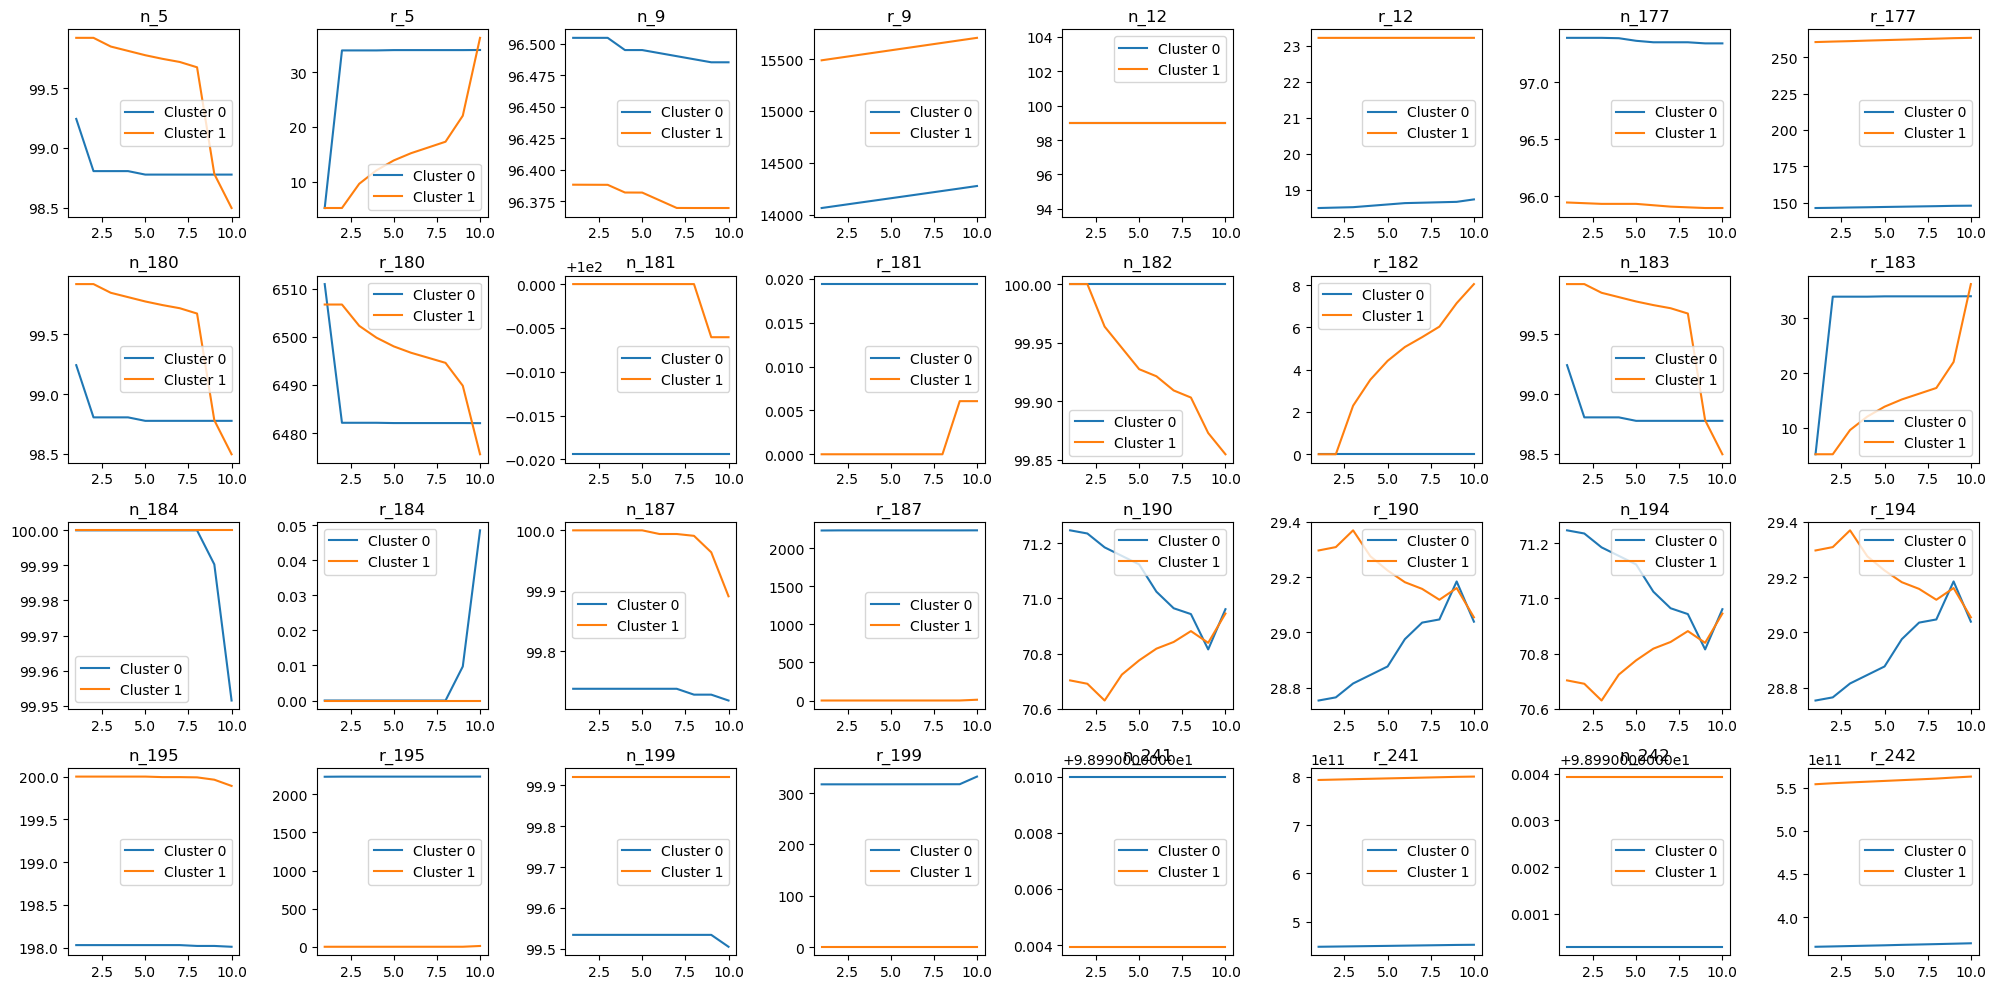

In [88]:
import matplotlib.pyplot as plt

# Assuming the dataframes are named 'cluster_0_mean_df', 'cluster_1_mean_df', 'cluster_2_mean_df', 'cluster_3_mean_df'
clusters = [cluster_0_mean_df, cluster_1_mean_df]
cluster_names = ['Cluster 0', 'Cluster 1']

# feature names list
feature_names = cluster_0_mean_df.columns.tolist()

# Create subplots with 4 rows and 8 columns, each cell will represent a feature
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

# Reshape the axes array to 1D for easy iteration
axs = axs.ravel()

for i in range(len(feature_names)):
    for j in range(2):
        # Plot each cluster's line in the same subplot (feature)
        axs[i].plot(clusters[j].index + 1, clusters[j].iloc[:, i], label=cluster_names[j])
        
    axs[i].set_title(feature_names[i])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [89]:
from sklearn.manifold import TSNE

x_data = to_cluster_df.drop(columns=['index','disk_id','label','cluster'])
# dim reduction with tsne
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method. not be used as preprocessing step of supervised learning
tsne_data = tsne.fit_transform(x_data)

Text(0, 0.5, 'Second principal component')

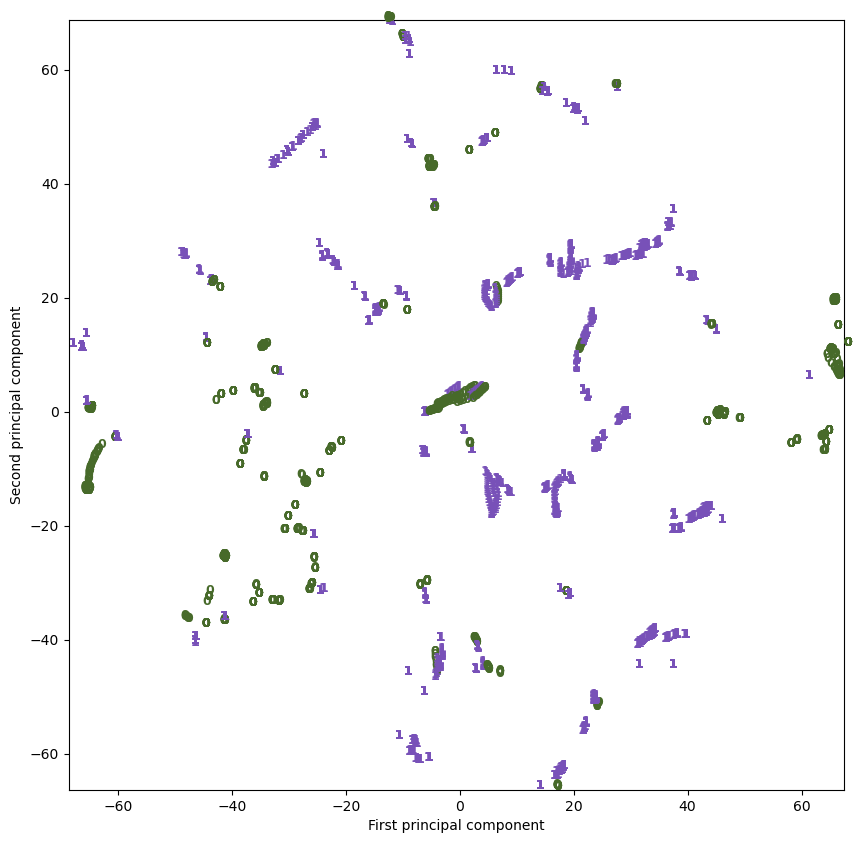

In [90]:
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(tsne_data[:, 0].min(), tsne_data[:, 0].max())
plt.ylim(tsne_data[:, 1].min(), tsne_data[:, 1].max())
for i in range(len(to_cluster_df)):
    # actually plot the digits as text instead of using scatter
    plt.text(tsne_data[i, 0], tsne_data[i, 1], str(list(to_cluster_df['cluster'])[i]),
             color = colors[list(to_cluster_df['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#상대적으로 잘 뭉쳐져있다! -> 시각화하는데 잘 사용됨.

- 잘 나눠졌는지 모르겠어서, 3차원으로 확인

In [92]:
import plotly.graph_objects as go

x_data = to_cluster_df.drop(columns=['index','disk_id','label','cluster'])

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=3, random_state=42) # set n_components to 3 for 3D
tsne_data = tsne.fit_transform(x_data)

# Prepare data for plotly
clusters = list(to_cluster_df['cluster'])
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
color_map = [colors[i] for i in clusters]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=tsne_data[:, 0],
    y=tsne_data[:, 1],
    z=tsne_data[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=color_map,  # set color to an array/list of desired values
    ),
    text=clusters,  # assign the cluster labels as hovertext
)])

# Update layout for better view
fig.update_layout(scene = dict(
                    xaxis_title='First principal component',
                    yaxis_title='Second principal component',
                    zaxis_title='Third principal component'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

- 0,1 클러스터는 거의 뭉쳐있음
- 0,1을 하나의 클러스터로 본다면, 총 3개의 클러스터로 묶을수 있을거같다.
- k=4 에서 k=3으로 설정하고 클러스터링 시도해보면 좋을거같음.

### DTW Kmeans

In [93]:
to_cluster = to_cluster_data.drop(columns=['index','label'])

grouped = to_cluster.groupby("disk_id").apply(np.array)

to_cluster = np.array(grouped.tolist())  # This is now a 3D array (n_samples, n_timestamps, n_features)
to_cluster = to_cluster[:, :, 1:]
to_cluster.shape

(268, 10, 32)

In [94]:
# Scale the data
scaler = TimeSeriesScalerMeanVariance()
data_scaled = scaler.fit_transform(to_cluster)

In [95]:
def calculate_scores(num_clusters, data_scaled):
    km_dtw = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw")
    clusters = km_dtw.fit_predict(data_scaled)
    silhouette = silhouette_score(data_scaled.reshape(data_scaled.shape[0], -1), clusters)
    inertia = km_dtw.inertia_
    return silhouette, inertia

In [96]:
num_clusters_range = range(2, 11)
silhouette_scores = []
inertia_scores = []

for k in num_clusters_range:
    silhouette, inertia = calculate_scores(k, data_scaled)
    silhouette_scores.append(silhouette)
    inertia_scores.append(inertia)

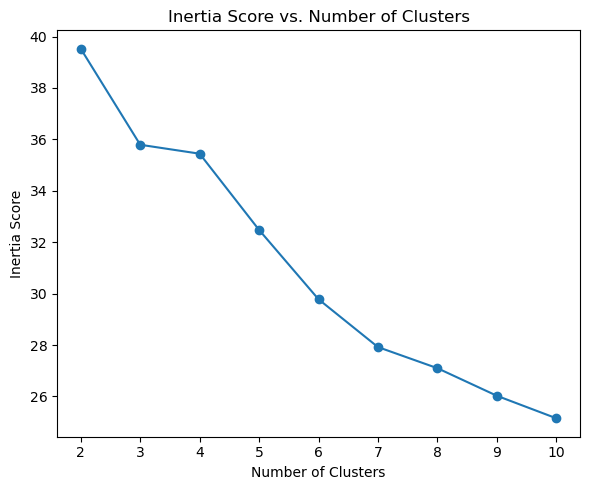

In [97]:
# Plot only the Inertia Score vs. Number of Clusters
plt.figure(figsize=(6, 5))
plt.plot(num_clusters_range, inertia_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Score")
plt.title("Inertia Score vs. Number of Clusters")
plt.tight_layout()
plt.show()

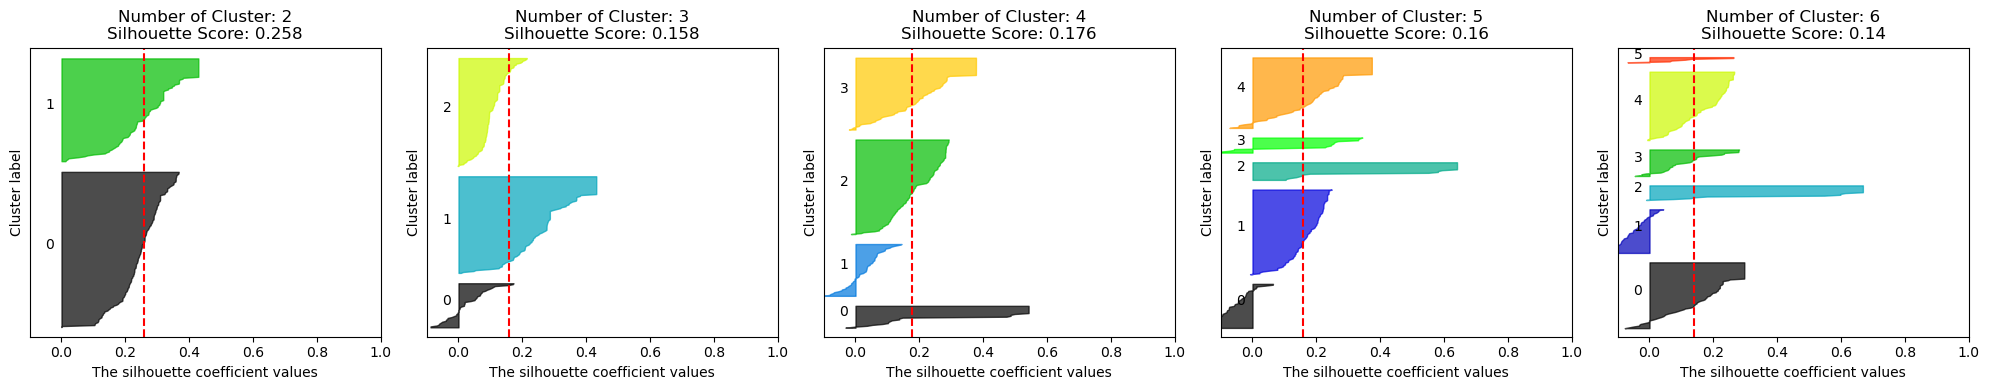

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score, silhouette_samples

# Assuming you have already scaled your time series data (data_scaled) using TimeSeriesScalerMeanVariance
def visualize_silhouette(cluster_lists, data_scaled):
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    # Flatten the 3-dimensional time series data into 2-dimensional array
    data_reshaped = data_scaled.reshape(data_scaled.shape[0], -1)

    for ind, n_cluster in enumerate(cluster_lists):
        km_dtw = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw", verbose=False)
        clusters = km_dtw.fit_predict(data_scaled)

        # Calculate the silhouette score on the reshaped data
        silhouette_avg = silhouette_score(data_reshaped, clusters)

        sample_silhouette_values = silhouette_samples(data_reshaped, clusters)
        y_lower = 10

        axs[ind].set_title('Number of Cluster: ' + str(n_cluster) + '\n'
                          'Silhouette Score: ' + str(round(silhouette_avg, 3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(data_scaled) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sample_silhouette_values[clusters == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=silhouette_avg, color="red", linestyle="--")

# Example usage with your data_scaled (assuming it's a NumPy array of time series data)
visualize_silhouette(range(2, 7), data_scaled)
plt.tight_layout()
plt.show()

In [99]:
# Choose the number of clusters (k) you want
k = 2

# Run the TimeSeriesKMeans algorithm with DTW distance
km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw")
clusters = km_dtw.fit_predict(data_scaled)

In [100]:
clusters

array([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0], dtype=int64)

In [101]:
to_cluster_df = to_cluster_data.copy()
to_cluster_df.reset_index(inplace=True,drop=True)

to_cluster_df['cluster']=0
for i, cluster in enumerate(clusters):
    to_cluster_df.loc[i*10:i*10+10, 'cluster'] = cluster
to_cluster_df

index  disk_id   n_5  r_5   n_9      r_9  n_12  r_12  n_177  r_177  \
0    2019-03-16    470.0  99.0  4.0  96.0  16054.0  99.0  18.0   99.0    7.0   
1    2019-03-17    470.0  99.0  4.0  96.0  16078.0  99.0  18.0   99.0    7.0   
2    2019-03-18    470.0  99.0  4.0  96.0  16102.0  99.0  18.0   99.0    7.0   
3    2019-03-19    470.0  99.0  4.0  96.0  16126.0  99.0  18.0   99.0    7.0   
4    2019-03-20    470.0  99.0  4.0  96.0  16150.0  99.0  18.0   99.0    7.0   
...         ...      ...   ...  ...   ...      ...   ...   ...    ...    ...   
2675 2019-03-21  44338.0  99.0  2.0  96.0  16176.0  99.0  21.0   99.0    6.0   
2676 2019-03-22  44338.0  99.0  2.0  96.0  16200.0  99.0  21.0   99.0    6.0   
2677 2019-03-23  44338.0  99.0  2.0  96.0  16224.0  99.0  21.0   99.0    6.0   
2678 2019-03-24  44338.0  99.0  2.0  96.0  16248.0  99.0  21.0   99.0    6.0   
2679 2019-03-25  44338.0  99.0  2.0  96.0  16272.0  99.0  21.0   99.0    6.0   

      ...  n_195  r_195  n_199  r_199  n_241         r_241  n_242  \
0     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
1     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
2     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
3     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
4     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
...   ...    ...    ...    ...    ...    ...           ...    ...   
2675  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
2676  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
2677  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
2678  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
2679  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   

             r_242  label  cluster  
0     8.743607e+09    0.0        0  
1     8.744597e+09    0.0        0  
2     8.745809e+09    0.0        0  
3     8.747037e+09    0.0        0  
4     8.748307e+09    0.0        0  
...            ...    ...      ...  
2675  8.778025e+09    0.0        0  
2676  8.779657e+09    0.0        0  
2677  8.781085e+09    0.0        0  
2678  8.782419e+09    0.0        0  
2679  8.783980e+09    1.0        0  

[2680 rows x 36 columns]

In [102]:
df = to_cluster_df.drop(columns=['index','label'])

cluster_0 = df[df['cluster']==0].drop('cluster',axis=1).copy()
cluster_1 = df[df['cluster']==1].drop('cluster',axis=1).copy()
#cluster_2 = df[df['cluster']==2].drop('cluster',axis=1).copy()
""" cluster_3 = df[df['cluster']==3].drop('cluster',axis=1).copy()
cluster_4 = df[df['cluster']==4].drop('cluster',axis=1).copy() """

cluster_0_grouped = cluster_0.groupby(['disk_id']).apply(np.array)
cluster_1_grouped = cluster_1.groupby(['disk_id']).apply(np.array)
#cluster_2_grouped = cluster_2.groupby(['disk_id']).apply(np.array)
""" cluster_3_grouped = cluster_3.groupby(['disk_id']).apply(np.array)
cluster_4_grouped = cluster_4.groupby(['disk_id']).apply(np.array) """

cluster_0_arr = np.array(cluster_0_grouped.tolist())  # This is now a 3D groupby (n_samples, n_timestamps, n_features)
cluster_1_arr = np.array(cluster_1_grouped.tolist())
#cluster_2_arr = np.array(cluster_2_grouped.tolist())
""" cluster_3_arr = np.array(cluster_3_grouped.tolist())
cluster_4_arr = np.array(cluster_4_grouped.tolist())
 """
print('cluster_0_arr 의 shpae:',cluster_0_arr.shape)
print('cluster_1_arr 의 shpae:',cluster_1_arr.shape)
#print('cluster_2_arr 의 shpae:',cluster_2_arr.shape)
""" print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)
print('cluster_4_arr 의 shpae:',cluster_4_arr.shape) """

cluster_0_arr 의 shpae: (105, 10, 33)
cluster_1_arr 의 shpae: (163, 10, 33)


" print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)\nprint('cluster_4_arr 의 shpae:',cluster_4_arr.shape) "

In [103]:
import numpy as np

# Calculate the mean along the first axis
cluster_0_mean_data = np.mean(cluster_0_arr, axis=0)
cluster_1_mean_data = np.mean(cluster_1_arr, axis=0)
cluster_2_mean_data = np.mean(cluster_2_arr, axis=0)
""" cluster_3_mean_data = np.mean(cluster_3_arr, axis=0)
cluster_4_mean_data = np.mean(cluster_4_arr, axis=0) """

# Now 'mean_data' has shape (10, 33)
print(cluster_0_mean_data.shape)  # Output: (10, 33)

(10, 33)


In [104]:
cluster_0_mean_df = pd.DataFrame(cluster_0_mean_data, columns=cluster_0.columns)
del(cluster_0_mean_df['disk_id'])

cluster_1_mean_df = pd.DataFrame(cluster_1_mean_data, columns=cluster_1.columns)
del(cluster_1_mean_df['disk_id'])

cluster_2_mean_df = pd.DataFrame(cluster_2_mean_data, columns=cluster_2.columns)
del(cluster_2_mean_df['disk_id'])

""" cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)
del(cluster_3_mean_df['disk_id'])

cluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)
del(cluster_4_mean_df['disk_id']) """

" cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)\ndel(cluster_3_mean_df['disk_id'])\n\ncluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)\ndel(cluster_4_mean_df['disk_id']) "

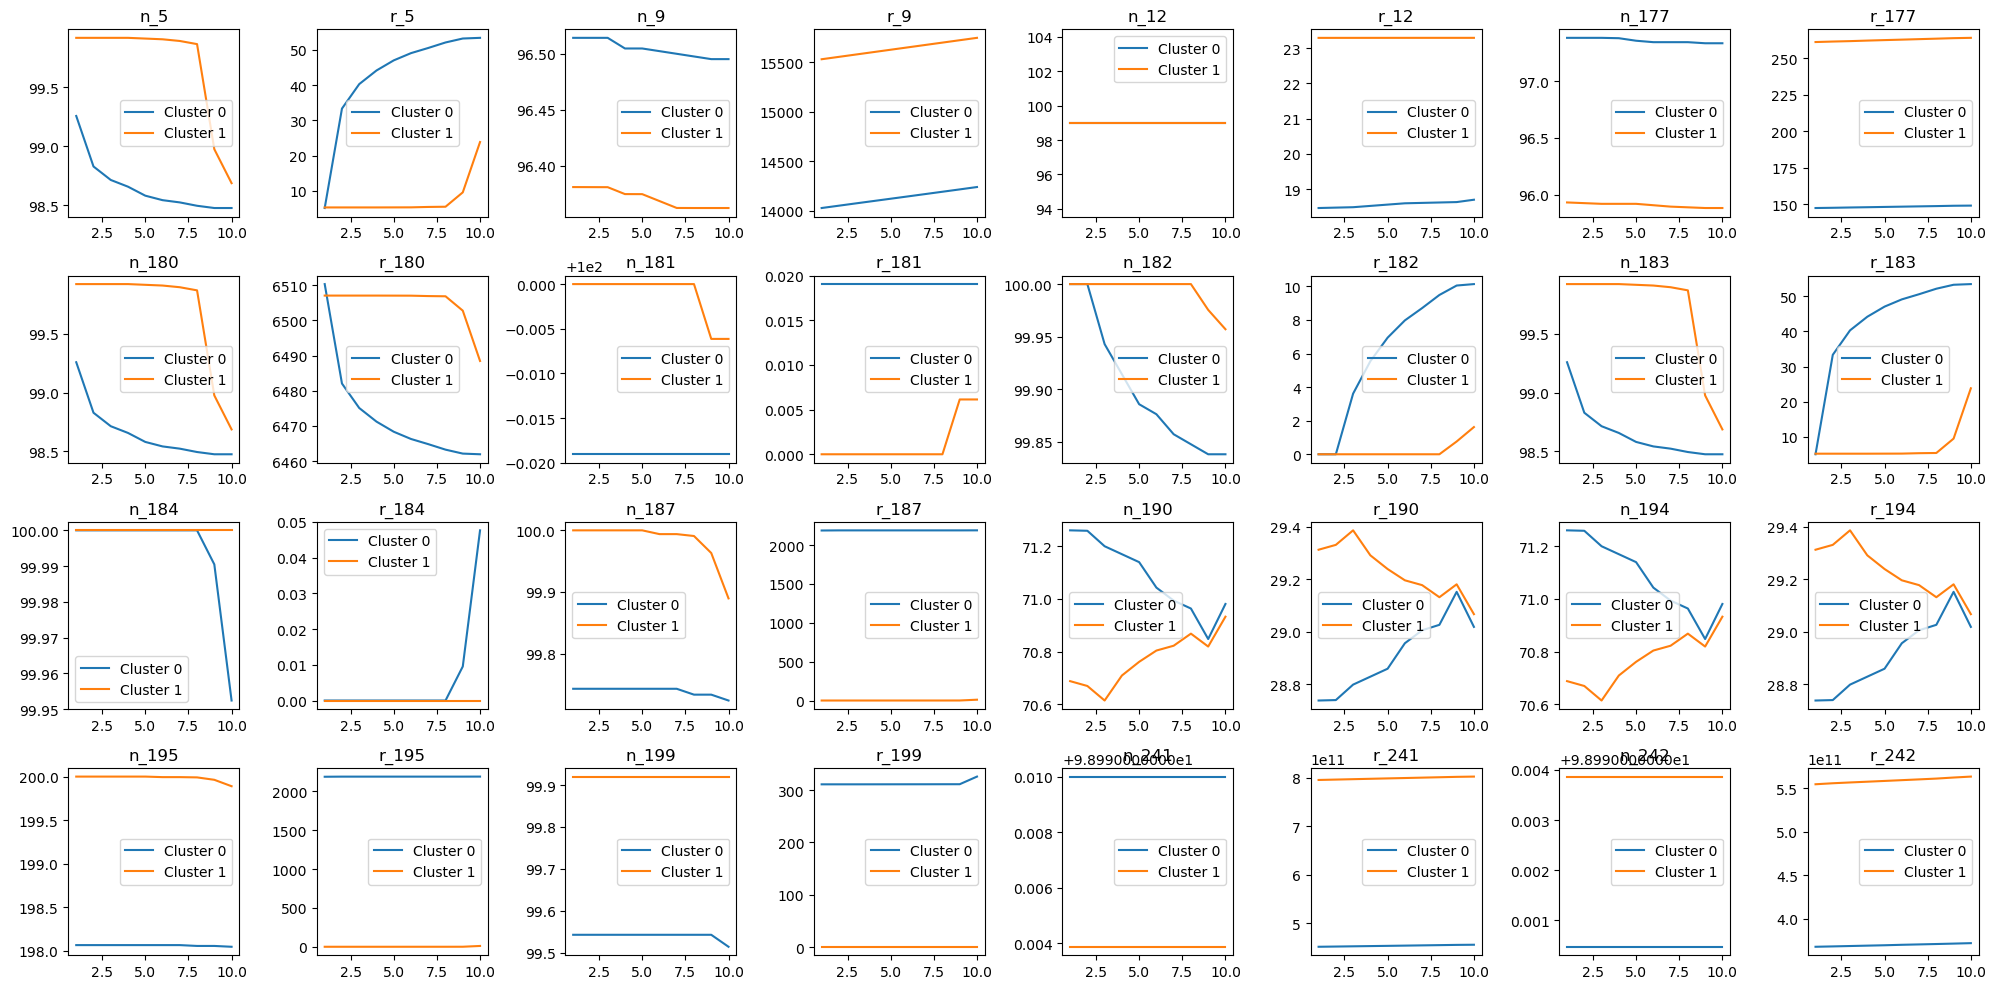

In [105]:
import matplotlib.pyplot as plt

# Assuming the dataframes are named 'cluster_0_mean_df', 'cluster_1_mean_df', 'cluster_2_mean_df', 'cluster_3_mean_df'
clusters = [cluster_0_mean_df, cluster_1_mean_df]
cluster_names = ['Cluster 0', 'Cluster 1']

# feature names list
feature_names = cluster_0_mean_df.columns.tolist()

# Create subplots with 4 rows and 8 columns, each cell will represent a feature
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

# Reshape the axes array to 1D for easy iteration
axs = axs.ravel()

for i in range(len(feature_names)):
    for j in range(2):
        # Plot each cluster's line in the same subplot (feature)
        axs[i].plot(clusters[j].index + 1, clusters[j].iloc[:, i], label=cluster_names[j])
        
    axs[i].set_title(feature_names[i])
    axs[i].legend()

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Second principal component')

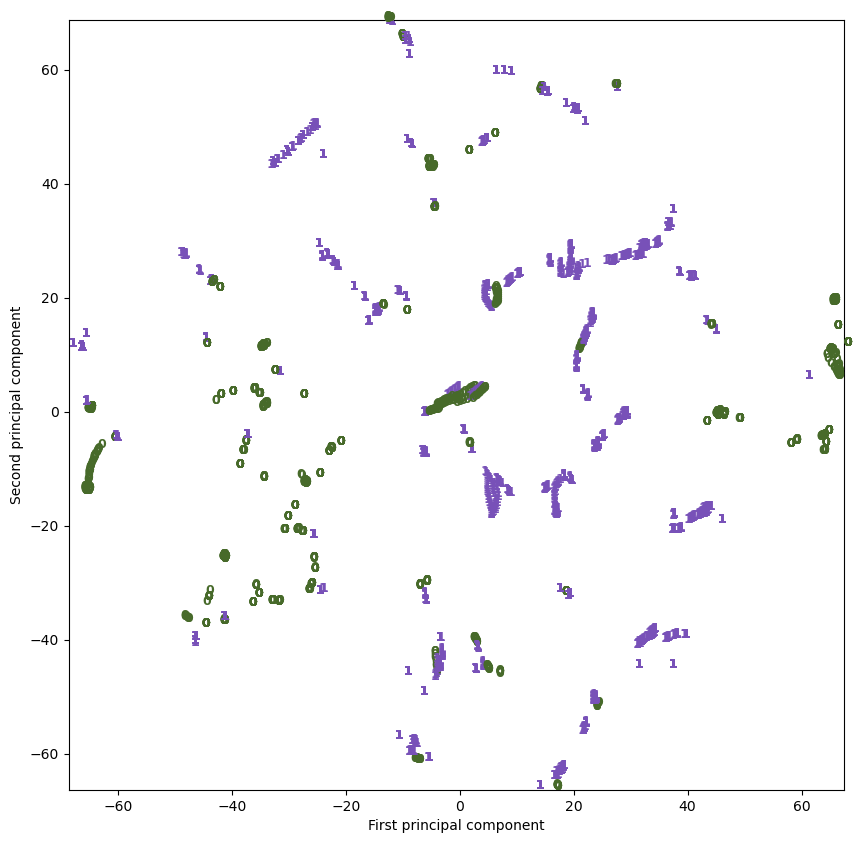

In [106]:
from sklearn.manifold import TSNE

x_data = to_cluster_df.drop(columns=['index','disk_id','label','cluster'])
# dim reduction with tsne
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method. not be used as preprocessing step of supervised learning
tsne_data = tsne.fit_transform(x_data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(tsne_data[:, 0].min(), tsne_data[:, 0].max())
plt.ylim(tsne_data[:, 1].min(), tsne_data[:, 1].max())
for i in range(len(to_cluster_df)):
    # actually plot the digits as text instead of using scatter
    plt.text(tsne_data[i, 0], tsne_data[i, 1], str(list(to_cluster_df['cluster'])[i]),
             color = colors[list(to_cluster_df['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#상대적으로 잘 뭉쳐져있다! -> 시각화하는데 잘 사용됨.

In [107]:
import plotly.graph_objects as go

x_data = to_cluster_df.drop(columns=['index','disk_id','label','cluster'])

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=3, random_state=42) # set n_components to 3 for 3D
tsne_data = tsne.fit_transform(x_data)

# Prepare data for plotly
clusters = list(to_cluster_df['cluster'])
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
color_map = [colors[i] for i in clusters]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=tsne_data[:, 0],
    y=tsne_data[:, 1],
    z=tsne_data[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=color_map,  # set color to an array/list of desired values
    ),
    text=clusters,  # assign the cluster labels as hovertext
)])

# Update layout for better view
fig.update_layout(scene = dict(
                    xaxis_title='First principal component',
                    yaxis_title='Second principal component',
                    zaxis_title='Third principal component'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

## DTW Kmeans(30일에 대해서)

In [120]:
data = pd.read_csv('../../ssd_data/combined_by_diskmodel/combined_MB1.csv',index_col=False)

# 데이터를 시간 순서대로 정렬 ('ds' 컬럼을 기준으로)
data = data.sort_values(by=['ds'])
data = data.drop_duplicates(subset=['disk_id', 'ds'])
data.reset_index(inplace=True)
del(data['index'])
del(data['level_0'])
data

disk_id        ds model  n_1  r_1    n_5  r_5   n_9      r_9  n_12  \
0          10005  20190101   MB1  NaN  NaN  100.0  0.0  99.0   4600.0  99.0   
1          39138  20190101   MB1  NaN  NaN  100.0  0.0  97.0  13256.0  99.0   
2           3918  20190101   MB1  NaN  NaN  100.0  0.0  97.0  13305.0  99.0   
3          39187  20190101   MB1  NaN  NaN  100.0  0.0  97.0  12934.0  99.0   
4          39189  20190101   MB1  NaN  NaN  100.0  0.0  97.0  12934.0  99.0   
...          ...       ...   ...  ...  ...    ...  ...   ...      ...   ...   
7132648    27627  20190630   MB1  NaN  NaN  100.0  0.0  96.0  17027.0  99.0   
7132649    27631  20190630   MB1  NaN  NaN  100.0  0.0  96.0  17027.0  99.0   
7132650    27676  20190630   MB1  NaN  NaN  100.0  0.0  96.0  18069.0  99.0   
7132651    27586  20190630   MB1  NaN  NaN  100.0  0.0  98.0   8476.0  99.0   
7132652     9975  20190630   MB1  NaN  NaN  100.0  0.0  96.0  17397.0  99.0   

         ...  r_244  n_245    r_245  n_175  r_175  n_232  r_232  label  n_211  \
0        ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
1        ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
2        ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
3        ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
4        ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
...      ...    ...    ...      ...    ...    ...    ...    ...    ...    ...   
7132648  ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
7132649  ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
7132650  ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
7132651  ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   
7132652  ...    0.0  100.0  65535.0    NaN    NaN    NaN    NaN      0    NaN   

         r_211  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
...        ...  
7132648    NaN  
7132649    NaN  
7132650    NaN  
7132651    NaN  
7132652    NaN  

[7132653 rows x 72 columns]

In [121]:
# null값이 있는 열을 제거하는 코드
def remove_null_columns(df):
    # null인 컬럼을 확인하고, 모든 값이 null인 컬럼을 찾습니다.
    null_columns = df.columns[df.isnull().all()]
    
    # 모든 값이 null인 컬럼을 DataFrame에서 제거합니다.
    df = df.drop(null_columns, axis=1)
    
    return df
# 하나의 unique한 값으로만 이루어진 컬럼을 제거하는 코드
def remove_single_value_columns(df):
    single_value_cols = []
    for col in df.columns:
        unique_values = df[col].nunique()
        if unique_values == 1:
            single_value_cols.append(col)

    df_filtered = df.drop(single_value_cols, axis=1)
    return df_filtered


In [122]:
data = remove_null_columns(data)
data = remove_single_value_columns(data)

failed된 disk_id중에서 첫 관측에서 마지막 관측의 결측치 채우기<br>
interpolate-linear

In [123]:
selected_disk_ids = data[data['label']==1]['disk_id'].unique()

dfs_to_concat = []  # 추가할 데이터프레임들을 저장할 리스트

for disk_id in selected_disk_ids:
    disk_data = data[data['disk_id'] == disk_id].copy()
    disk_data['ds'] = pd.to_datetime(disk_data['ds'], format='%Y%m%d')
    disk_data = disk_data.sort_values(by='ds')
    disk_data = disk_data.set_index('ds', drop=True)
    all_dates = pd.date_range(start=disk_data.index.min(), end=disk_data.index.max(), freq='D')
    disk_data = disk_data.reindex(all_dates)
    disk_data = disk_data.interpolate(method='linear')
    dfs_to_concat.append(disk_data)

interpolated_data = pd.concat(dfs_to_concat)  # 데이터프레임들을 연결하여 새로운 데이터프레임 생성

interpolated_data = interpolated_data.reset_index()  # 인덱스 재설정
interpolated_data

index  disk_id    n_5  r_5   n_9      r_9  n_12  r_12  n_177  \
0     2019-01-01  17909.0   99.0  2.0  97.0  12819.0  99.0  19.0   97.0   
1     2019-01-02  17909.0   99.0  2.0  97.0  12843.0  99.0  19.0   97.0   
2     2019-01-03  17909.0   99.0  2.0  97.0  12867.0  99.0  19.0   97.0   
3     2019-01-04  17909.0   99.0  2.0  97.0  12891.0  99.0  19.0   97.0   
4     2019-01-05  17909.0   99.0  2.0  97.0  12915.0  99.0  19.0   97.0   
...          ...      ...    ...  ...   ...      ...   ...   ...    ...   
43895 2019-06-26   8599.0  100.0  0.0  96.0  17168.0  99.0  21.0   91.0   
43896 2019-06-27   8599.0  100.0  0.0  96.0  17192.0  99.0  21.0   91.0   
43897 2019-06-28   8599.0  100.0  0.0  96.0  17216.0  99.0  21.0   91.0   
43898 2019-06-29   8599.0   99.0  2.0  96.0  17240.0  99.0  21.0   91.0   
43899 2019-06-30   8599.0   99.0  2.0  96.0  17264.0  99.0  21.0   91.0   

       r_177  ...  r_194  n_195  r_195  n_199  r_199  n_241         r_241  \
0      155.0  ...   32.0  199.0    1.0  100.0    0.0   99.0  4.761304e+11   
1      155.0  ...   31.0  199.0    1.0  100.0    0.0   99.0  4.774871e+11   
2      156.0  ...   31.0  199.0    1.0  100.0    0.0   99.0  4.790559e+11   
3      156.0  ...   32.0  199.0    1.0  100.0    0.0   99.0  4.805626e+11   
4      157.0  ...   31.0  199.0    1.0  100.0    0.0   99.0  4.819720e+11   
...      ...  ...    ...    ...    ...    ...    ...    ...           ...   
43895  623.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201000e+12   
43896  623.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201312e+12   
43897  624.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  2.201585e+12   
43898  624.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201871e+12   
43899  624.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201928e+12   

       n_242         r_242  label  
0       99.0  3.422788e+11    1.0  
1       99.0  3.432220e+11    0.0  
2       99.0  3.467700e+11    0.0  
3       99.0  3.477830e+11    0.0  
4       99.0  3.512526e+11    0.0  
...      ...           ...    ...  
43895   99.0  8.356453e+11    0.0  
43896   99.0  8.362658e+11    0.0  
43897   99.0  8.371074e+11    0.0  
43898   99.0  8.379656e+11    0.0  
43899   99.0  8.381230e+11    1.0  

[43900 rows x 35 columns]

처음관측 됐을때부터 fail이 일어날때까지 30일 이하이면 디스크 아이디를 없앤다

In [124]:
selected_disk_model_1 = interpolated_data['disk_id'].unique()

to_delete_id =[]
for disk_id in selected_disk_model_1:
    disk_data = interpolated_data[interpolated_data['disk_id'] == disk_id].copy()
    disk_data = disk_data.sort_values(by='index')
    disk_data.reset_index(inplace=True,drop=True)

    failed_index = disk_data[disk_data['label']==1]['index'].index.min()
    start_index = disk_data.index.min()

    if(failed_index - start_index) < 29:
        to_delete_id.append(disk_id)

# failed_disk_index에 해당하는 행들을 제거
interploated_data_failed = interpolated_data[~interpolated_data['disk_id'].isin(to_delete_id)]
interploated_data_failed

index  disk_id    n_5  r_5   n_9      r_9  n_12  r_12  n_177  \
4148  2019-01-01  41400.0  100.0  0.0  97.0  12694.0  99.0  13.0   99.0   
4149  2019-01-02  41400.0  100.0  0.0  97.0  12718.0  99.0  13.0   99.0   
4150  2019-01-03  41400.0  100.0  0.0  97.0  12742.0  99.0  13.0   99.0   
4151  2019-01-04  41400.0  100.0  0.0  97.0  12766.0  99.0  13.0   99.0   
4152  2019-01-05  41400.0  100.0  0.0  97.0  12790.0  99.0  13.0   99.0   
...          ...      ...    ...  ...   ...      ...   ...   ...    ...   
43895 2019-06-26   8599.0  100.0  0.0  96.0  17168.0  99.0  21.0   91.0   
43896 2019-06-27   8599.0  100.0  0.0  96.0  17192.0  99.0  21.0   91.0   
43897 2019-06-28   8599.0  100.0  0.0  96.0  17216.0  99.0  21.0   91.0   
43898 2019-06-29   8599.0   99.0  2.0  96.0  17240.0  99.0  21.0   91.0   
43899 2019-06-30   8599.0   99.0  2.0  96.0  17264.0  99.0  21.0   91.0   

       r_177  ...  r_194  n_195  r_195  n_199  r_199  n_241         r_241  \
4148    55.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.812450e+11   
4149    55.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.813687e+11   
4150    56.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.815201e+11   
4151    56.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.816743e+11   
4152    56.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.818216e+11   
...      ...  ...    ...    ...    ...    ...    ...    ...           ...   
43895  623.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201000e+12   
43896  623.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201312e+12   
43897  624.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  2.201585e+12   
43898  624.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201871e+12   
43899  624.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  2.201928e+12   

       n_242         r_242  label  
4148    99.0  1.329623e+11    0.0  
4149    99.0  1.333035e+11    0.0  
4150    99.0  1.336394e+11    0.0  
4151    99.0  1.339799e+11    0.0  
4152    99.0  1.343434e+11    0.0  
...      ...           ...    ...  
43895   99.0  8.356453e+11    0.0  
43896   99.0  8.362658e+11    0.0  
43897   99.0  8.371074e+11    0.0  
43898   99.0  8.379656e+11    0.0  
43899   99.0  8.381230e+11    1.0  

[39091 rows x 35 columns]

In [125]:
# 라벨이 1인 행을 필터링합니다.
selected_disk_model_1 = interploated_data_failed[interploated_data_failed['label'] == 1]

# 모델, disk_id, 그리고 날짜 순으로 정렬합니다.
selected_disk_model_1 = selected_disk_model_1.sort_values(by=['disk_id', 'index'])

# disk_id와 model 열만을 선택하여 새로운 데이터 프레임에 저장합니다.
selected_disk_model_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)

# 결과 데이터 프레임을 출력합니다.
selected_disk_model_1.shape

(244, 1)

In [126]:
to_cluster_data = pd.DataFrame()

for disk_id in selected_disk_model_1['disk_id'].unique():
    disk_data = interploated_data_failed[interploated_data_failed['disk_id'] == disk_id].copy()
    disk_data = disk_data.sort_values(by='index')
    disk_data.reset_index(inplace=True,drop=True)

    failed_index = disk_data[disk_data['label']==1]['index'].index.min()
    before_9day_index = failed_index - 29

    to_cluster = disk_data.iloc[before_9day_index:failed_index+1, :]
    to_cluster_data = pd.concat([to_cluster_data,to_cluster],axis=0)
    
to_cluster_data

index  disk_id   n_5  r_5   n_9      r_9  n_12  r_12  n_177  r_177  \
54 2019-02-24    470.0  99.0  4.0  96.0  15574.0  99.0  18.0   99.0    7.0   
55 2019-02-25    470.0  99.0  4.0  96.0  15598.0  99.0  18.0   99.0    7.0   
56 2019-02-26    470.0  99.0  4.0  96.0  15622.0  99.0  18.0   99.0    7.0   
57 2019-02-27    470.0  99.0  4.0  96.0  15646.0  99.0  18.0   99.0    7.0   
58 2019-02-28    470.0  99.0  4.0  96.0  15670.0  99.0  18.0   99.0    7.0   
..        ...      ...   ...  ...   ...      ...   ...   ...    ...    ...   
79 2019-03-21  44338.0  99.0  2.0  96.0  16176.0  99.0  21.0   99.0    6.0   
80 2019-03-22  44338.0  99.0  2.0  96.0  16200.0  99.0  21.0   99.0    6.0   
81 2019-03-23  44338.0  99.0  2.0  96.0  16224.0  99.0  21.0   99.0    6.0   
82 2019-03-24  44338.0  99.0  2.0  96.0  16248.0  99.0  21.0   99.0    6.0   
83 2019-03-25  44338.0  99.0  2.0  96.0  16272.0  99.0  21.0   99.0    6.0   

    ...  r_194  n_195  r_195  n_199  r_199  n_241         r_241  n_242  \
54  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
55  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
56  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
57  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
58  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
..  ...    ...    ...    ...    ...    ...    ...           ...    ...   
79  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
80  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
81  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
82  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
83  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   

           r_242  label  
54  8.718806e+09    0.0  
55  8.720226e+09    0.0  
56  8.721518e+09    0.0  
57  8.722888e+09    0.0  
58  8.724136e+09    0.0  
..           ...    ...  
79  8.778025e+09    0.0  
80  8.779657e+09    0.0  
81  8.781085e+09    0.0  
82  8.782419e+09    0.0  
83  8.783980e+09    1.0  

[7320 rows x 35 columns]

In [127]:
to_cluster_fail = to_cluster_data.drop(columns=['index','label'])

grouped = to_cluster_fail.groupby("disk_id").apply(np.array)

to_cluster_fail = np.array(grouped.tolist())  # This is now a 3D array (n_samples, n_timestamps, n_features)
to_cluster_fail = to_cluster_fail[:, :, 1:]
to_cluster_fail.shape

(244, 30, 32)

healthy한 디스크 244개에서 한개씩 가져온다 

In [128]:
import random

# label이 0인 데이터 필터링
filtered_data = data[data['label'] == 0]

# disk_id 중복 제거
unique_disk_ids = filtered_data['disk_id'].unique()

selected_disk_ids = []

# 244개의 disk_id를 랜덤으로 선택
while len(selected_disk_ids) < 244:
    # 아직 선택되지 않은 disk_id들 중 랜덤으로 선택
    remaining_disk_ids = [disk_id for disk_id in unique_disk_ids if disk_id not in selected_disk_ids]
    disk_id = random.choice(remaining_disk_ids)
    
    # 선택된 disk_id의 데이터 추출
    selected_data = data[data['disk_id'] == disk_id]

    # 하나의 disk_id의 행 개수가 180개 이상인 것들
    if len(selected_data) >= 180:
        selected_disk_ids.append(disk_id)


In [129]:
len(selected_disk_ids)

244

In [130]:
# 결과 출력 (selected_disk_ids 리스트에 있는 disk_id의 데이터 추출)
selected_data = data[data['disk_id'].isin(selected_disk_ids)]
selected_data

disk_id        ds    n_5  r_5   n_9      r_9  n_12  r_12  n_177  \
75         38402  20190101  100.0  0.0  97.0  12081.0  99.0  31.0   99.0   
86         37318  20190101  100.0  0.0  97.0  13302.0  99.0  17.0   99.0   
385        29721  20190101  100.0  0.0  99.0   1804.0  99.0  16.0   99.0   
587         3410  20190101  100.0  0.0  97.0  13179.0  99.0  19.0   97.0   
600         4346  20190101  100.0  0.0  97.0  12819.0  99.0  17.0   99.0   
...          ...       ...    ...  ...   ...      ...   ...   ...    ...   
7131929    15221  20190630  100.0  0.0  96.0  16717.0  99.0  32.0   95.0   
7132004    13706  20190630  100.0  0.0  96.0  17238.0  99.0  18.0   99.0   
7132378    24913  20190630  100.0  0.0  96.0  17241.0  99.0  15.0   99.0   
7132440     2281  20190630  100.0  0.0  96.0  17305.0  99.0  14.0   99.0   
7132582    27024  20190630  100.0  0.0  96.0  17022.0  99.0  12.0   99.0   

         r_177  ...  r_194  n_195  r_195  n_199  r_199  n_241         r_241  \
75        45.0  ...   28.0  200.0    0.0  100.0    0.0   99.0  9.519753e+10   
86        70.0  ...   33.0  200.0    0.0  100.0    0.0   99.0  9.804987e+10   
385       15.0  ...   26.0  200.0    0.0  100.0    0.0   99.0  3.024546e+10   
587      173.0  ...   29.0  200.0    0.0  100.0    0.0   99.0  5.126497e+11   
600       23.0  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.902542e+10   
...        ...  ...    ...    ...    ...    ...    ...    ...           ...   
7131929  313.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  4.755997e+11   
7132004    7.0  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.440423e+10   
7132378    8.0  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.441640e+10   
7132440   23.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  1.071021e+10   
7132582   24.0  ...   29.0  200.0    0.0  100.0    0.0   99.0  1.103691e+10   

         n_242         r_242  label  
75        99.0  6.200996e+10      0  
86        99.0  5.413970e+10      0  
385       99.0  8.566001e+09      0  
587       99.0  3.141020e+11      0  
600       99.0  2.547576e+09      0  
...        ...           ...    ...  
7131929   99.0  2.806890e+10      0  
7132004   99.0  4.035205e+08      0  
7132378   99.0  4.000311e+08      0  
7132440   99.0  3.875162e+11      0  
7132582   99.0  3.003000e+09      0  

[43920 rows x 35 columns]

In [131]:
dfs_to_concat = []  # 추가할 데이터프레임들을 저장할 리스트

for disk_id in selected_disk_ids:
    disk_data = data[data['disk_id'] == disk_id].copy()
    disk_data['ds'] = pd.to_datetime(disk_data['ds'], format='%Y%m%d')
    disk_data = disk_data.sort_values(by='ds')
    disk_data = disk_data.set_index('ds', drop=True)
    all_dates = pd.date_range(start=disk_data.index.min(), end=disk_data.index.max(), freq='D')
    disk_data = disk_data.reindex(all_dates)
    disk_data = disk_data.interpolate(method='linear')
    dfs_to_concat.append(disk_data)

interpolated_data_healthy = pd.concat(dfs_to_concat)  # 데이터프레임들을 연결하여 새로운 데이터프레임 생성

interpolated_data_healthy = interpolated_data_healthy.reset_index()  # 인덱스 재설정
interpolated_data_healthy

index  disk_id    n_5  r_5   n_9      r_9  n_12  r_12  n_177  \
0     2019-01-01  19585.0  100.0  0.0  97.0  12707.0  99.0  17.0   99.0   
1     2019-01-02  19585.0  100.0  0.0  97.0  12731.0  99.0  17.0   99.0   
2     2019-01-03  19585.0  100.0  0.0  97.0  12755.0  99.0  17.0   99.0   
3     2019-01-04  19585.0  100.0  0.0  97.0  12779.0  99.0  17.0   99.0   
4     2019-01-05  19585.0  100.0  0.0  97.0  12803.0  99.0  17.0   99.0   
...          ...      ...    ...  ...   ...      ...   ...   ...    ...   
44159 2019-06-26  29447.0  100.0  0.0  98.0   9206.0  99.0  15.0   97.0   
44160 2019-06-27  29447.0  100.0  0.0  98.0   9230.0  99.0  15.0   97.0   
44161 2019-06-28  29447.0  100.0  0.0  98.0   9254.0  99.0  15.0   97.0   
44162 2019-06-29  29447.0  100.0  0.0  98.0   9278.0  99.0  15.0   97.0   
44163 2019-06-30  29447.0  100.0  0.0  98.0   9302.0  99.0  15.0   97.0   

       r_177  ...  r_194  n_195  r_195  n_199  r_199  n_241         r_241  \
0       33.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  5.983440e+10   
1       33.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  6.161174e+10   
2       34.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  6.305941e+10   
3       34.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  6.399891e+10   
4       34.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  6.488292e+10   
...      ...  ...    ...    ...    ...    ...    ...    ...           ...   
44159  189.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  3.995664e+11   
44160  190.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  4.005778e+11   
44161  191.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  4.018019e+11   
44162  191.0  ...   31.0  200.0    0.0  100.0    0.0   99.0  4.027139e+11   
44163  192.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  4.035957e+11   

       n_242         r_242  label  
0       99.0  3.205076e+10    0.0  
1       99.0  3.225149e+10    0.0  
2       99.0  3.244970e+10    0.0  
3       99.0  3.263840e+10    0.0  
4       99.0  3.283030e+10    0.0  
...      ...           ...    ...  
44159   99.0  3.440685e+11    0.0  
44160   99.0  3.447617e+11    0.0  
44161   99.0  3.458317e+11    0.0  
44162   99.0  3.467983e+11    0.0  
44163   99.0  3.477033e+11    0.0  

[44164 rows x 35 columns]

In [132]:
disk_data = filtered_data[filtered_data['disk_id'] == 5790.0]
disk_data

disk_id        ds    n_5  r_5   n_9      r_9  n_12  r_12  n_177  \
22196       5790  20190101  100.0  0.0  97.0  12933.0  99.0  27.0   96.0   
66865       5790  20190102  100.0  0.0  97.0  12957.0  99.0  27.0   96.0   
99274       5790  20190103  100.0  0.0  97.0  12981.0  99.0  27.0   96.0   
136985      5790  20190104  100.0  0.0  97.0  13005.0  99.0  27.0   96.0   
185453      5790  20190105  100.0  0.0  97.0  13029.0  99.0  27.0   96.0   
...          ...       ...    ...  ...   ...      ...   ...   ...    ...   
6935826     5790  20190626  100.0  0.0  96.0  17156.0  99.0  27.0   94.0   
6991968     5790  20190627  100.0  0.0  96.0  17180.0  99.0  27.0   94.0   
7034486     5790  20190628  100.0  0.0  96.0  17204.0  99.0  27.0   94.0   
7057858     5790  20190629  100.0  0.0  96.0  17228.0  99.0  27.0   94.0   
7103150     5790  20190630  100.0  0.0  96.0  17252.0  99.0  27.0   94.0   

         r_177  ...  r_194  n_195  r_195  n_199  r_199  n_241         r_241  \
22196    284.0  ...   32.0  200.0    0.0  100.0    0.0   99.0  7.171349e+11   
66865    285.0  ...   32.0  200.0    0.0  100.0    0.0   99.0  7.183169e+11   
99274    285.0  ...   32.0  200.0    0.0  100.0    0.0   99.0  7.196048e+11   
136985   286.0  ...   32.0  200.0    0.0  100.0    0.0   99.0  7.207343e+11   
185453   287.0  ...   32.0  200.0    0.0  100.0    0.0   99.0  7.217348e+11   
...        ...  ...    ...    ...    ...    ...    ...    ...           ...   
6935826  390.0  ...   33.0  200.0    0.0  100.0    0.0   99.0  8.974247e+11   
6991968  390.0  ...   33.0  200.0    0.0  100.0    0.0   99.0  8.986457e+11   
7034486  391.0  ...   33.0  200.0    0.0  100.0    0.0   99.0  8.994951e+11   
7057858  391.0  ...   33.0  200.0    0.0  100.0    0.0   99.0  9.002956e+11   
7103150  392.0  ...   33.0  200.0    0.0  100.0    0.0   99.0  9.010787e+11   

         n_242         r_242  label  
22196     99.0  4.438803e+11      0  
66865     99.0  4.446525e+11      0  
99274     99.0  4.454824e+11      0  
136985    99.0  4.462582e+11      0  
185453    99.0  4.469809e+11      0  
...        ...           ...    ...  
6935826   99.0  5.722663e+11      0  
6991968   99.0  5.731796e+11      0  
7034486   99.0  5.738259e+11      0  
7057858   99.0  5.743744e+11      0  
7103150   99.0  5.748468e+11      0  

[180 rows x 35 columns]

In [133]:
selected_data_list = []
unique_disk_ids = interpolated_data_healthy['disk_id'].unique()
for disk_id in unique_disk_ids:
    disk_data = interpolated_data_healthy[interpolated_data_healthy['disk_id'] == disk_id]
    index_list = disk_data.index.tolist()
    start_index = random.choice(index_list[:-29])
    selected_indexes = index_list[index_list.index(start_index):index_list.index(start_index) + 30]
    selected_data = disk_data.loc[selected_indexes]
    selected_data_list.append(selected_data)
result_data = pd.concat(selected_data_list)

In [134]:
result_data

index  disk_id    n_5  r_5   n_9      r_9  n_12  r_12  n_177  \
14    2019-01-15  19585.0  100.0  0.0  97.0  13043.0  99.0  17.0   99.0   
15    2019-01-16  19585.0  100.0  0.0  97.0  13067.0  99.0  17.0   99.0   
16    2019-01-17  19585.0  100.0  0.0  97.0  13091.0  99.0  17.0   99.0   
17    2019-01-18  19585.0  100.0  0.0  97.0  13115.0  99.0  17.0   99.0   
18    2019-01-19  19585.0  100.0  0.0  97.0  13139.0  99.0  17.0   99.0   
...          ...      ...    ...  ...   ...      ...   ...   ...    ...   
44076 2019-04-04  29447.0  100.0  0.0  98.0   7214.0  99.0  15.0   98.0   
44077 2019-04-05  29447.0  100.0  0.0  98.0   7238.0  99.0  15.0   98.0   
44078 2019-04-06  29447.0  100.0  0.0  98.0   7262.0  99.0  15.0   98.0   
44079 2019-04-07  29447.0  100.0  0.0  98.0   7286.0  99.0  15.0   98.0   
44080 2019-04-08  29447.0  100.0  0.0  98.0   7310.0  99.0  15.0   98.0   

       r_177  ...  r_194  n_195  r_195  n_199  r_199  n_241         r_241  \
14      36.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  6.982201e+10   
15      37.0  ...   29.0  200.0    0.0  100.0    0.0   99.0  7.024457e+10   
16      37.0  ...   29.0  200.0    0.0  100.0    0.0   99.0  7.076719e+10   
17      37.0  ...   28.0  200.0    0.0  100.0    0.0   99.0  7.114233e+10   
18      37.0  ...   29.0  200.0    0.0  100.0    0.0   99.0  7.141424e+10   
...      ...  ...    ...    ...    ...    ...    ...    ...           ...   
44076  129.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  3.132278e+11   
44077  130.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  3.140707e+11   
44078  130.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  3.149185e+11   
44079  131.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  3.157156e+11   
44080  131.0  ...   30.0  200.0    0.0  100.0    0.0   99.0  3.165960e+11   

       n_242         r_242  label  
14      99.0  3.334992e+10    0.0  
15      99.0  3.352703e+10    0.0  
16      99.0  3.370339e+10    0.0  
17      99.0  3.388137e+10    0.0  
18      99.0  3.405831e+10    0.0  
...      ...           ...    ...  
44076   99.0  2.608310e+11    0.0  
44077   99.0  2.614299e+11    0.0  
44078   99.0  2.619992e+11    0.0  
44079   99.0  2.625417e+11    0.0  
44080   99.0  2.632073e+11    0.0  

[7320 rows x 35 columns]

In [135]:
to_cluster_healthy = result_data.drop(columns=['index','label'])

grouped = to_cluster_healthy.groupby("disk_id").apply(np.array)

to_cluster_healthy = np.array(grouped.tolist())  # This is now a 3D array (n_samples, n_timestamps, n_features)
to_cluster_healthy = to_cluster_healthy[:, :, 1:]
to_cluster_healthy.shape

(244, 30, 32)

In [136]:
print(to_cluster_healthy.shape)
print(to_cluster_fail.shape)

(244, 30, 32)
(244, 30, 32)


In [140]:
# 두 개의 데이터를 하나의 (488, 30, 32) 형태로 합치기
combined_data = np.concatenate([to_cluster_healthy, to_cluster_fail], axis=0)
to_cluster=combined_data
print(to_cluster.shape)

(488, 30, 32)


In [141]:
# Scale the data
scaler = TimeSeriesScalerMeanVariance()
data_scaled = scaler.fit_transform(to_cluster)

In [142]:
def calculate_scores(num_clusters, data_scaled):
    km_dtw = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw")
    clusters = km_dtw.fit_predict(data_scaled)
    silhouette = silhouette_score(data_scaled.reshape(data_scaled.shape[0], -1), clusters)
    inertia = km_dtw.inertia_
    return silhouette, inertia

In [143]:
num_clusters_range = range(2, 11)
silhouette_scores = []
inertia_scores = []

for k in num_clusters_range:
    silhouette, inertia = calculate_scores(k, data_scaled)
    silhouette_scores.append(silhouette)
    inertia_scores.append(inertia)

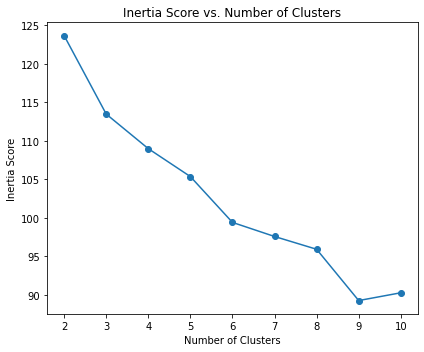

In [144]:
# Plot only the Inertia Score vs. Number of Clusters
plt.figure(figsize=(6, 5))
plt.plot(num_clusters_range, inertia_scores, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia Score")
plt.title("Inertia Score vs. Number of Clusters")
plt.tight_layout()
plt.show()

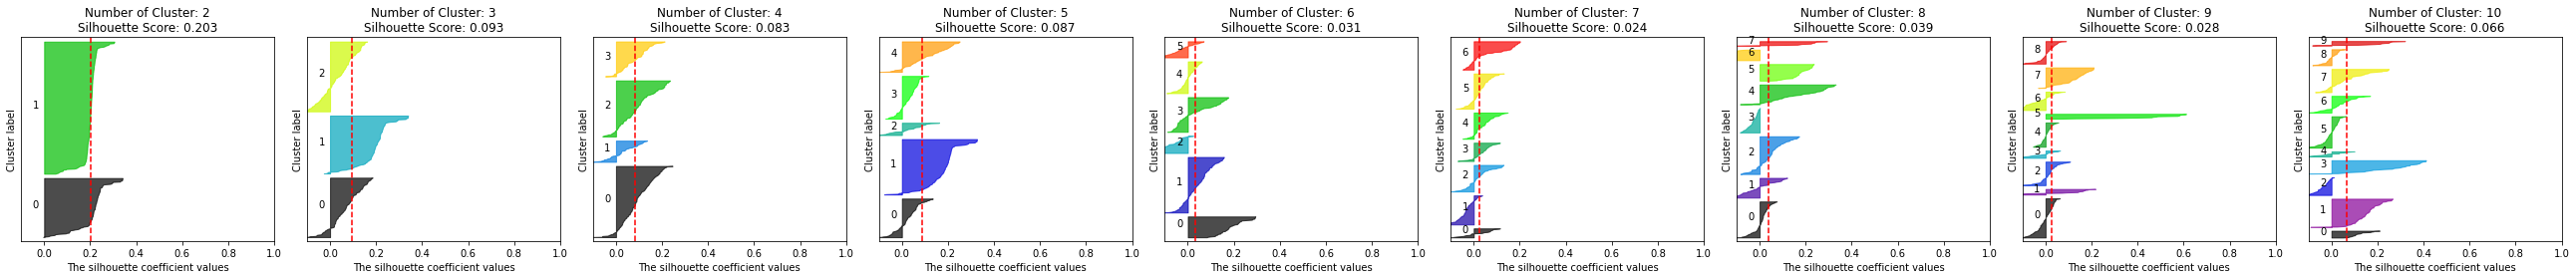

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score, silhouette_samples

# Assuming you have already scaled your time series data (data_scaled) using TimeSeriesScalerMeanVariance
def visualize_silhouette(cluster_lists, data_scaled):
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)
    
    (244,30*32)

    (7320,32)

    # Flatten the 3-dimensional time series data into 2-dimensional array
    data_reshaped = data_scaled.reshape(data_scaled.shape[0], -1)

    for ind, n_cluster in enumerate(cluster_lists):
        km_dtw = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw", verbose=False)
        clusters = km_dtw.fit_predict(data_scaled)

        # Calculate the silhouette score on the reshaped data
        silhouette_avg = silhouette_score(data_reshaped, clusters)

        sample_silhouette_values = silhouette_samples(data_reshaped, clusters)
        y_lower = 10

        axs[ind].set_title('Number of Cluster: ' + str(n_cluster) + '\n'
                          'Silhouette Score: ' + str(round(silhouette_avg, 3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(data_scaled) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sample_silhouette_values[clusters == i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=silhouette_avg, color="red", linestyle="--")

# Example usage with your data_scaled (assuming it's a NumPy array of time series data)
visualize_silhouette(range(2, 11), data_scaled)
plt.tight_layout()
plt.show()

- k= 3

In [149]:
# Choose the number of clusters (k) you want
k = 2

# Run the TimeSeriesKMeans algorithm with DTW distance
km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw")
clusters = km_dtw.fit_predict(data_scaled)

In [150]:
clusters

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,

In [157]:
to_cluster

array([[[1.00000000e+02, 0.00000000e+00, 9.70000000e+01, ...,
         1.68449847e+11, 9.90000000e+01, 4.62836517e+11],
        [1.00000000e+02, 0.00000000e+00, 9.70000000e+01, ...,
         1.68696410e+11, 9.90000000e+01, 4.63818744e+11],
        [1.00000000e+02, 0.00000000e+00, 9.70000000e+01, ...,
         1.68992256e+11, 9.90000000e+01, 4.64756018e+11],
        ...,
        [1.00000000e+02, 0.00000000e+00, 9.70000000e+01, ...,
         1.73967461e+11, 9.90000000e+01, 4.77844831e+11],
        [1.00000000e+02, 0.00000000e+00, 9.70000000e+01, ...,
         1.74332612e+11, 9.90000000e+01, 4.78560943e+11],
        [1.00000000e+02, 0.00000000e+00, 9.70000000e+01, ...,
         1.74687064e+11, 9.90000000e+01, 4.79709536e+11]],

       [[1.00000000e+02, 0.00000000e+00, 9.70000000e+01, ...,
         1.71444181e+11, 9.90000000e+01, 3.03920195e+11],
        [1.00000000e+02, 0.00000000e+00, 9.70000000e+01, ...,
         1.71555985e+11, 9.90000000e+01, 3.04141996e+11],
        [1.00000000e+02, 

In [158]:
fail = to_cluster_data.drop(columns=['index','label'])
healthy = result_data.drop(columns=['index','label'])

In [160]:
# 데이터프레임 행으로 결합 (concat)
to_cluster_data = pd.concat([fail, healthy], ignore_index=True)

to_cluster_data

disk_id    n_5  r_5   n_9      r_9  n_12  r_12  n_177  r_177  n_180  \
0        470.0   99.0  4.0  96.0  15574.0  99.0  18.0   99.0    7.0   99.0   
1        470.0   99.0  4.0  96.0  15598.0  99.0  18.0   99.0    7.0   99.0   
2        470.0   99.0  4.0  96.0  15622.0  99.0  18.0   99.0    7.0   99.0   
3        470.0   99.0  4.0  96.0  15646.0  99.0  18.0   99.0    7.0   99.0   
4        470.0   99.0  4.0  96.0  15670.0  99.0  18.0   99.0    7.0   99.0   
...        ...    ...  ...   ...      ...   ...   ...    ...    ...    ...   
14635  29447.0  100.0  0.0  98.0   7214.0  99.0  15.0   98.0  129.0  100.0   
14636  29447.0  100.0  0.0  98.0   7238.0  99.0  15.0   98.0  130.0  100.0   
14637  29447.0  100.0  0.0  98.0   7262.0  99.0  15.0   98.0  130.0  100.0   
14638  29447.0  100.0  0.0  98.0   7286.0  99.0  15.0   98.0  131.0  100.0   
14639  29447.0  100.0  0.0  98.0   7310.0  99.0  15.0   98.0  131.0  100.0   

       ...  n_194  r_194  n_195  r_195  n_199  r_199  n_241         r_241  \
0      ...   71.0   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   
1      ...   71.0   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   
2      ...   71.0   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   
3      ...   71.0   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   
4      ...   71.0   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   
...    ...    ...    ...    ...    ...    ...    ...    ...           ...   
14635  ...   70.0   30.0  200.0    0.0  100.0    0.0   99.0  3.132278e+11   
14636  ...   70.0   30.0  200.0    0.0  100.0    0.0   99.0  3.140707e+11   
14637  ...   70.0   30.0  200.0    0.0  100.0    0.0   99.0  3.149185e+11   
14638  ...   70.0   30.0  200.0    0.0  100.0    0.0   99.0  3.157156e+11   
14639  ...   70.0   30.0  200.0    0.0  100.0    0.0   99.0  3.165960e+11   

       n_242         r_242  
0       99.0  8.718806e+09  
1       99.0  8.720226e+09  
2       99.0  8.721518e+09  
3       99.0  8.722888e+09  
4       99.0  8.724136e+09  
...      ...           ...  
14635   99.0  2.608310e+11  
14636   99.0  2.614299e+11  
14637   99.0  2.619992e+11  
14638   99.0  2.625417e+11  
14639   99.0  2.632073e+11  

[14640 rows x 33 columns]

In [161]:
to_cluster_df = to_cluster_data.copy()
to_cluster_df.reset_index(inplace=True,drop=True)

to_cluster_df['cluster']=0
for i, cluster in enumerate(clusters):
    to_cluster_df.loc[i*30:i*30+30, 'cluster'] = cluster
to_cluster_df

disk_id    n_5  r_5   n_9      r_9  n_12  r_12  n_177  r_177  n_180  \
0        470.0   99.0  4.0  96.0  15574.0  99.0  18.0   99.0    7.0   99.0   
1        470.0   99.0  4.0  96.0  15598.0  99.0  18.0   99.0    7.0   99.0   
2        470.0   99.0  4.0  96.0  15622.0  99.0  18.0   99.0    7.0   99.0   
3        470.0   99.0  4.0  96.0  15646.0  99.0  18.0   99.0    7.0   99.0   
4        470.0   99.0  4.0  96.0  15670.0  99.0  18.0   99.0    7.0   99.0   
...        ...    ...  ...   ...      ...   ...   ...    ...    ...    ...   
14635  29447.0  100.0  0.0  98.0   7214.0  99.0  15.0   98.0  129.0  100.0   
14636  29447.0  100.0  0.0  98.0   7238.0  99.0  15.0   98.0  130.0  100.0   
14637  29447.0  100.0  0.0  98.0   7262.0  99.0  15.0   98.0  130.0  100.0   
14638  29447.0  100.0  0.0  98.0   7286.0  99.0  15.0   98.0  131.0  100.0   
14639  29447.0  100.0  0.0  98.0   7310.0  99.0  15.0   98.0  131.0  100.0   

       ...  r_194  n_195  r_195  n_199  r_199  n_241         r_241  n_242  \
0      ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
1      ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
2      ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
3      ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
4      ...   29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
...    ...    ...    ...    ...    ...    ...    ...           ...    ...   
14635  ...   30.0  200.0    0.0  100.0    0.0   99.0  3.132278e+11   99.0   
14636  ...   30.0  200.0    0.0  100.0    0.0   99.0  3.140707e+11   99.0   
14637  ...   30.0  200.0    0.0  100.0    0.0   99.0  3.149185e+11   99.0   
14638  ...   30.0  200.0    0.0  100.0    0.0   99.0  3.157156e+11   99.0   
14639  ...   30.0  200.0    0.0  100.0    0.0   99.0  3.165960e+11   99.0   

              r_242  cluster  
0      8.718806e+09        1  
1      8.720226e+09        1  
2      8.721518e+09        1  
3      8.722888e+09        1  
4      8.724136e+09        1  
...             ...      ...  
14635  2.608310e+11        1  
14636  2.614299e+11        1  
14637  2.619992e+11        1  
14638  2.625417e+11        1  
14639  2.632073e+11        1  

[14640 rows x 34 columns]

In [165]:

cluster_0 = to_cluster_df[to_cluster_df['cluster']==0].drop('cluster',axis=1).copy()
cluster_1 = to_cluster_df[to_cluster_df['cluster']==1].drop('cluster',axis=1).copy()
# cluster_2 = to_cluster_df[to_cluster_df['cluster']==2].drop('cluster',axis=1).copy()
""" cluster_3 = to_cluster_df[to_cluster_df['cluster']==3].drop('cluster',axis=1).copy()
cluster_4 = to_cluster_df[to_cluster_df['cluster']==4].drop('cluster',axis=1).copy() """

cluster_0_grouped = cluster_0.groupby(['disk_id']).apply(np.array)
cluster_1_grouped = cluster_1.groupby(['disk_id']).apply(np.array)
# cluster_2_grouped = cluster_2.groupby(['disk_id']).apply(np.array)
""" cluster_3_grouped = cluster_3.groupby(['disk_id']).apply(np.array)
cluster_4_grouped = cluster_4.groupby(['disk_id']).apply(np.array) """

cluster_0_arr = np.array(cluster_0_grouped.tolist())  # This is now a 3D groupby (n_samples, n_timestamps, n_features)
cluster_1_arr = np.array(cluster_1_grouped.tolist())
# cluster_2_arr = np.array(cluster_2_grouped.tolist())
""" cluster_3_arr = np.array(cluster_3_grouped.tolist())
cluster_4_arr = np.array(cluster_4_grouped.tolist())
 """
print('cluster_0_arr 의 shpae:',cluster_0_arr.shape)
print('cluster_1_arr 의 shpae:',cluster_1_arr.shape)
# print('cluster_2_arr 의 shpae:',cluster_2_arr.shape)
""" print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)
print('cluster_4_arr 의 shpae:',cluster_4_arr.shape) """

cluster_0_arr 의 shpae: (151, 30, 33)
cluster_1_arr 의 shpae: (336,)


C:\Users\passion\AppData\Local\Temp/ipykernel_16700/2357232704.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cluster_1_arr = np.array(cluster_1_grouped.tolist())


" print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)\nprint('cluster_4_arr 의 shpae:',cluster_4_arr.shape) "

In [167]:
import numpy as np

# Calculate the mean along the first axis
cluster_0_mean_data = np.mean(cluster_0_arr, axis=0)
cluster_1_mean_data = np.mean(cluster_1_arr, axis=0)
# cluster_2_mean_data = np.mean(cluster_2_arr, axis=0)
""" cluster_3_mean_data = np.mean(cluster_3_arr, axis=0)
cluster_4_mean_data = np.mean(cluster_4_arr, axis=0) """

# Now 'mean_data' has shape (10, 33)
print(cluster_0_mean_data.shape)  # Output: (10, 33)

ValueError: operands could not be broadcast together with shapes (30,33) (60,33) 

In [25]:
cluster_0_mean_df = pd.DataFrame(cluster_0_mean_data, columns=cluster_0.columns)
del(cluster_0_mean_df['disk_id'])

cluster_1_mean_df = pd.DataFrame(cluster_1_mean_data, columns=cluster_1.columns)
del(cluster_1_mean_df['disk_id'])

# cluster_2_mean_df = pd.DataFrame(cluster_2_mean_data, columns=cluster_2.columns)
# del(cluster_2_mean_df['disk_id'])

""" cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)
del(cluster_3_mean_df['disk_id'])

cluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)
del(cluster_4_mean_df['disk_id']) """

" cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)\ndel(cluster_3_mean_df['disk_id'])\n\ncluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)\ndel(cluster_4_mean_df['disk_id']) "

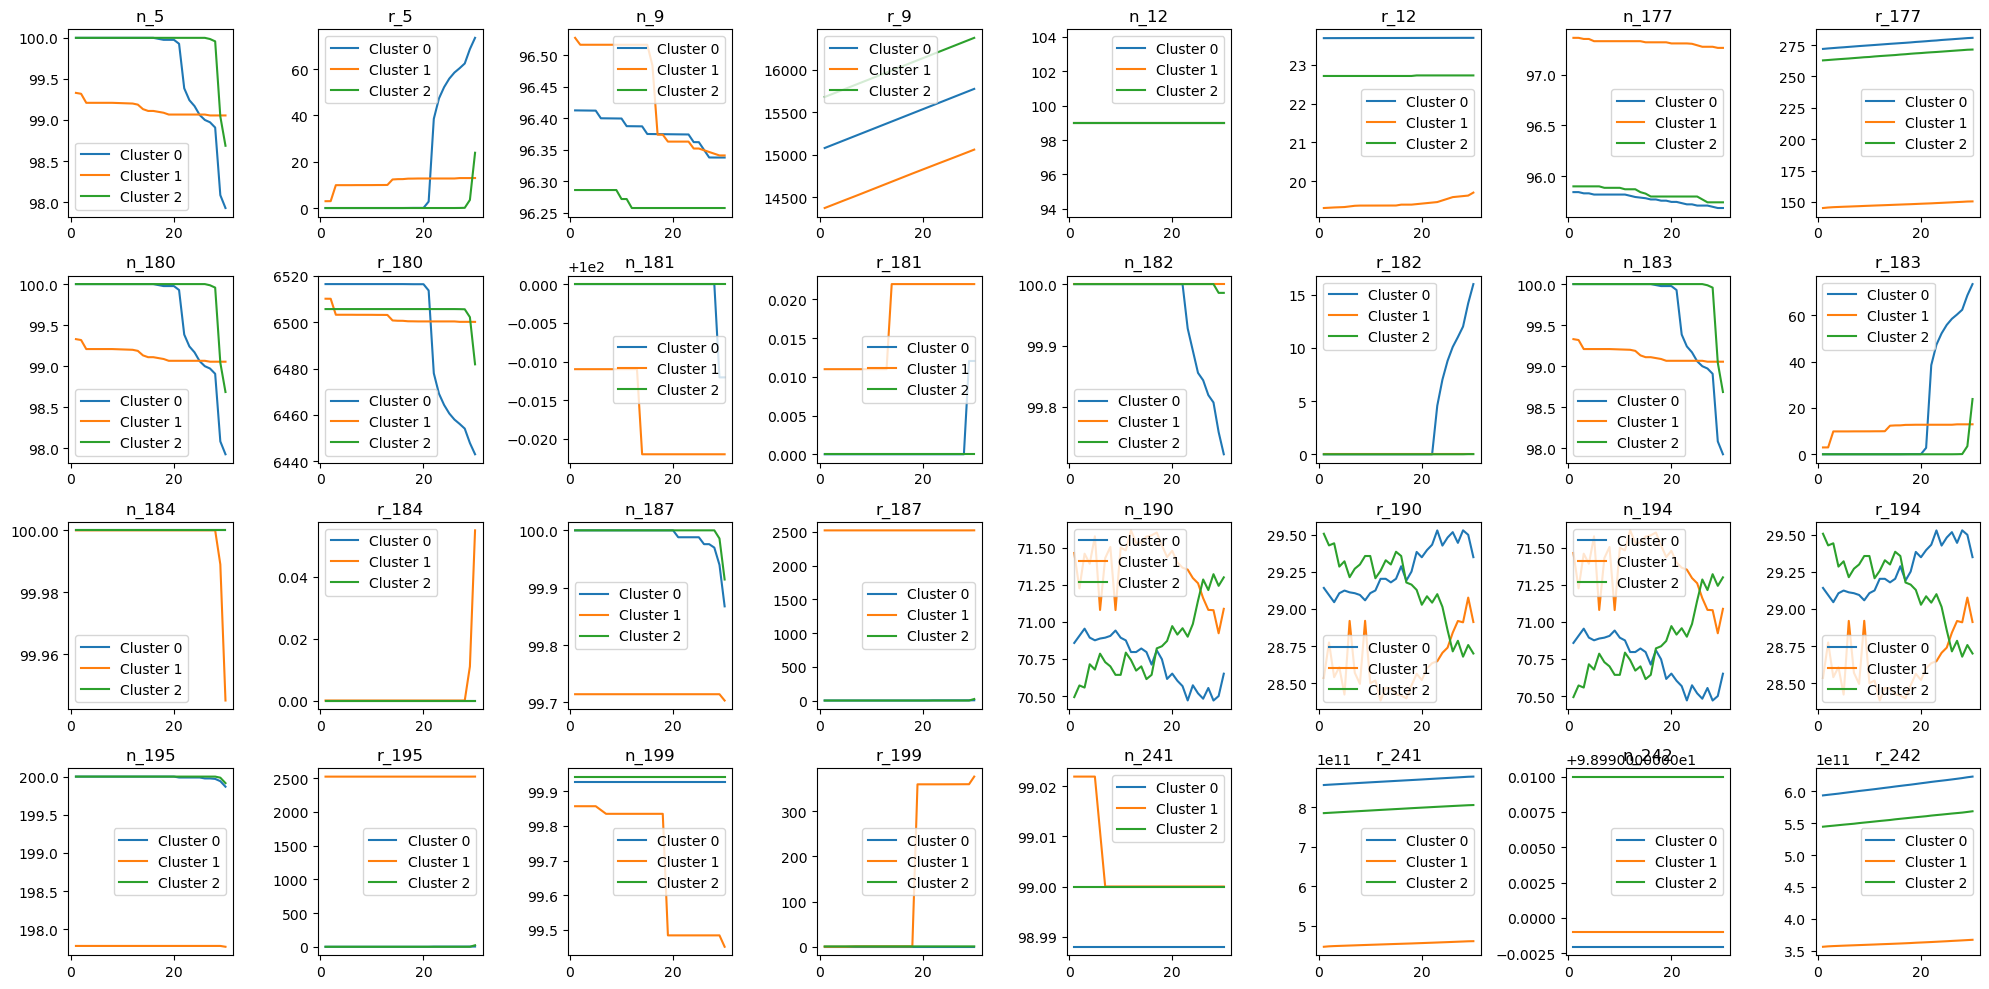

In [26]:
import matplotlib.pyplot as plt

# Assuming the dataframes are named 'cluster_0_mean_df', 'cluster_1_mean_df', 'cluster_2_mean_df', 'cluster_3_mean_df'
clusters = [cluster_0_mean_df, cluster_1_mean_df,cluster_2_mean_df]
cluster_names = ['Cluster 0', 'Cluster 1','Cluster 2']

# feature names list
feature_names = cluster_0_mean_df.columns.tolist()

# Create subplots with 4 rows and 8 columns, each cell will represent a feature
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

# Reshape the axes array to 1D for easy iteration
axs = axs.ravel()

for i in range(len(feature_names)):
    for j in range(3):
        # Plot each cluster's line in the same subplot (feature)
        axs[i].plot(clusters[j].index + 1, clusters[j].iloc[:, i], label=cluster_names[j])
        
    axs[i].set_title(feature_names[i])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [27]:
to_cluster_df.to_csv('../../ssd_data/clustering_data/DTW_Kmeans_3.csv')

In [30]:
cluster_0_id= to_cluster_df[to_cluster_df['cluster']==0]['disk_id'].unique()
cluster_1_id= to_cluster_df[to_cluster_df['cluster']==1]['disk_id'].unique()
cluster_2_id= to_cluster_df[to_cluster_df['cluster']==2]['disk_id'].unique()

In [33]:
data[data['disk_id']==cluster_0_id[0]]

index  disk_id    n_5  r_5   n_9      r_9  n_12  r_12  n_177  \
39776 2019-01-01    601.0  100.0  0.0  97.0  13145.0  99.0  18.0   97.0   
39777 2019-01-02    601.0  100.0  0.0  97.0  13169.0  99.0  18.0   97.0   
39778 2019-01-03    601.0  100.0  0.0  97.0  13193.0  99.0  18.0   97.0   
39779 2019-01-04    601.0  100.0  0.0  97.0  13217.0  99.0  18.0   97.0   
39780 2019-01-05    601.0  100.0  0.0  97.0  13241.0  99.0  18.0   97.0   
...          ...      ...    ...  ...   ...      ...   ...   ...    ...   
39952 2019-06-26    601.0   99.0  2.0  96.0  17366.0  99.0  18.0   96.0   
39953 2019-06-27    601.0   99.0  2.0  96.0  17390.0  99.0  18.0   96.0   
39954 2019-06-28    601.0   99.0  2.0  96.0  17414.0  99.0  18.0   96.0   
39955 2019-06-29    601.0   99.0  2.0  96.0  17438.0  99.0  18.0   96.0   
39956 2019-06-30    601.0   99.0  2.0  96.0  17462.0  99.0  18.0   96.0   

       r_177  ...  r_194  n_195  r_195  n_199  r_199  n_241         r_241  \
39776  188.0  ...   26.0  200.0    0.0  100.0    0.0   99.0  6.382424e+11   
39777  189.0  ...   26.0  200.0    0.0  100.0    0.0   99.0  6.410735e+11   
39778  190.0  ...   26.0  200.0    0.0  100.0    0.0   99.0  6.440735e+11   
39779  191.0  ...   26.0  200.0    0.0  100.0    0.0   99.0  6.469741e+11   
39780  192.0  ...   26.0  200.0    0.0  100.0    0.0   99.0  6.498371e+11   
...      ...  ...    ...    ...    ...    ...    ...    ...           ...   
39952  294.0  ...   27.0  200.0    0.0  100.0    0.0   99.0  9.476637e+11   
39953  294.0  ...   27.0  200.0    0.0  100.0    0.0   99.0  9.476637e+11   
39954  294.0  ...   27.0  200.0    0.0  100.0    0.0   99.0  9.476637e+11   
39955  294.0  ...   27.0  200.0    0.0  100.0    0.0   99.0  9.476637e+11   
39956  294.0  ...   27.0  200.0    0.0  100.0    0.0   99.0  9.476637e+11   

       n_242         r_242  label  
39776   99.0  4.851654e+11    0.0  
39777   99.0  4.870629e+11    0.0  
39778   99.0  4.890647e+11    0.0  
39779   99.0  4.910458e+11    0.0  
39780   99.0  4.930077e+11    0.0  
...      ...           ...    ...  
39952   99.0  7.742962e+11    0.0  
39953   99.0  7.742962e+11    0.0  
39954   99.0  7.742962e+11    0.0  
39955   99.0  7.742962e+11    0.0  
39956   99.0  7.742962e+11    0.0  

[181 rows x 35 columns]

In [ ]:
import matplotlib.pyplot as plt

# Assuming the dataframes are named 'cluster_0_mean_df', 'cluster_1_mean_df', 'cluster_2_mean_df', 'cluster_3_mean_df'
sample_id = cluster_0_id[0]

# feature names list
feature_names = cluster_0_mean_df.columns.tolist()

# Create subplots with 4 rows and 8 columns, each cell will represent a feature
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

# Reshape the axes array to 1D for easy iteration
axs = axs.ravel()

for i in range(len(feature_names)):
    # Plot each cluster's line in the same subplot (feature)
    axs[i].plot(clusters[i].index + 1, clusters[i].iloc[:, i])
    axs[i].set_title(feature_names[i])
    axs[i].legend()

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Second principal component')

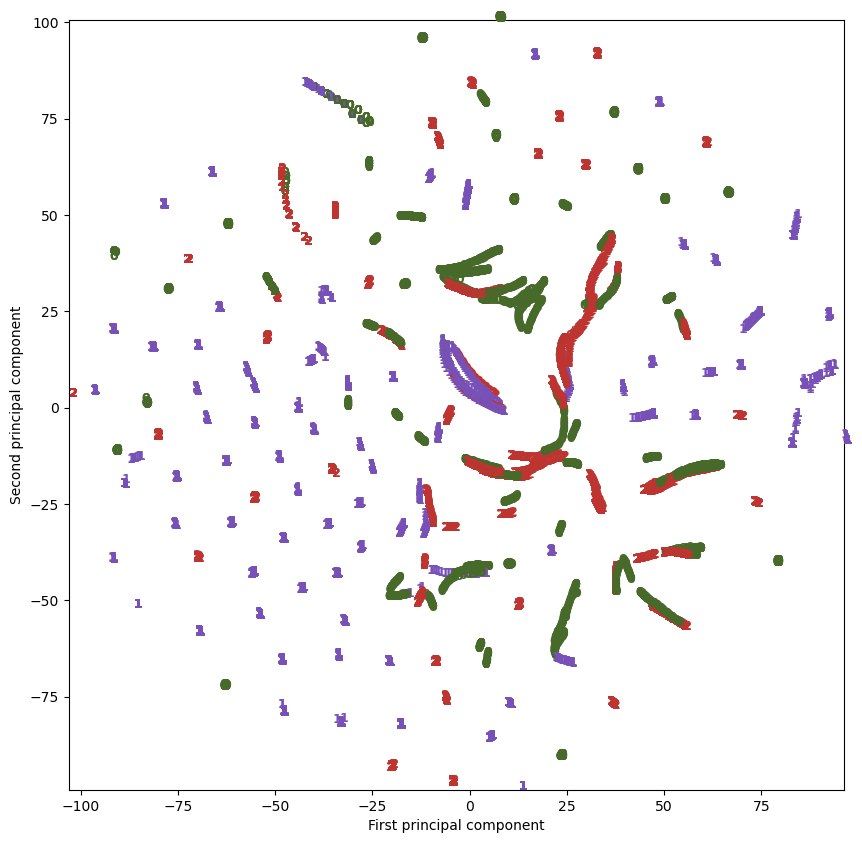

In [28]:
from sklearn.manifold import TSNE

x_data = to_cluster_df.drop(columns=['index','disk_id','label','cluster'])
# dim reduction with tsne
tsne = TSNE(random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method. not be used as preprocessing step of supervised learning
tsne_data = tsne.fit_transform(x_data)
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
plt.figure(figsize=(10, 10))
plt.xlim(tsne_data[:, 0].min(), tsne_data[:, 0].max())
plt.ylim(tsne_data[:, 1].min(), tsne_data[:, 1].max())
for i in range(len(to_cluster_df)):
    # actually plot the digits as text instead of using scatter
    plt.text(tsne_data[i, 0], tsne_data[i, 1], str(list(to_cluster_df['cluster'])[i]),
             color = colors[list(to_cluster_df['cluster'])[i]],
             fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
#상대적으로 잘 뭉쳐져있다! -> 시각화하는데 잘 사용됨.

In [ ]:
import plotly.graph_objects as go

x_data = to_cluster_df.drop(columns=['index','disk_id','label','cluster'])

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=3, random_state=42) # set n_components to 3 for 3D
tsne_data = tsne.fit_transform(x_data)

# Prepare data for plotly
clusters = list(to_cluster_df['cluster'])
colors = ["#476A2A", "#7851B8", "#BD3430", "#4A2D4E", "#875525",
          "#A83683", "#4E655E", "#853541", "#3A3120", "#535D8E"]
color_map = [colors[i] for i in clusters]

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=tsne_data[:, 0],
    y=tsne_data[:, 1],
    z=tsne_data[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=color_map,  # set color to an array/list of desired values
    ),
    text=clusters,  # assign the cluster labels as hovertext
)])

# Update layout for better view
fig.update_layout(scene = dict(
                    xaxis_title='First principal component',
                    yaxis_title='Second principal component',
                    zaxis_title='Third principal component'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

### cluster 잘 나눠져 있는지 확인

In [50]:
import pandas as pd

data = pd.read_csv('../../ssd_data/clustering_data/DTW_Kmeans_3.csv')
del(data['Unnamed: 0'])
data

index  disk_id   n_5  r_5   n_9      r_9  n_12  r_12  n_177  r_177  \
0     2019-02-24    470.0  99.0  4.0  96.0  15574.0  99.0  18.0   99.0    7.0   
1     2019-02-25    470.0  99.0  4.0  96.0  15598.0  99.0  18.0   99.0    7.0   
2     2019-02-26    470.0  99.0  4.0  96.0  15622.0  99.0  18.0   99.0    7.0   
3     2019-02-27    470.0  99.0  4.0  96.0  15646.0  99.0  18.0   99.0    7.0   
4     2019-02-28    470.0  99.0  4.0  96.0  15670.0  99.0  18.0   99.0    7.0   
...          ...      ...   ...  ...   ...      ...   ...   ...    ...    ...   
7315  2019-03-21  44338.0  99.0  2.0  96.0  16176.0  99.0  21.0   99.0    6.0   
7316  2019-03-22  44338.0  99.0  2.0  96.0  16200.0  99.0  21.0   99.0    6.0   
7317  2019-03-23  44338.0  99.0  2.0  96.0  16224.0  99.0  21.0   99.0    6.0   
7318  2019-03-24  44338.0  99.0  2.0  96.0  16248.0  99.0  21.0   99.0    6.0   
7319  2019-03-25  44338.0  99.0  2.0  96.0  16272.0  99.0  21.0   99.0    6.0   

      ...  n_195  r_195  n_199  r_199  n_241         r_241  n_242  \
0     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
1     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
2     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
3     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
4     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
...   ...    ...    ...    ...    ...    ...           ...    ...   
7315  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
7316  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
7317  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
7318  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
7319  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   

             r_242  label  cluster  
0     8.718806e+09    0.0        1  
1     8.720226e+09    0.0        1  
2     8.721518e+09    0.0        1  
3     8.722888e+09    0.0        1  
4     8.724136e+09    0.0        1  
...            ...    ...      ...  
7315  8.778025e+09    0.0        1  
7316  8.779657e+09    0.0        1  
7317  8.781085e+09    0.0        1  
7318  8.782419e+09    0.0        1  
7319  8.783980e+09    1.0        1  

[7320 rows x 36 columns]

In [51]:
data['index']=pd.to_datetime(data['index'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7320 entries, 0 to 7319
Data columns (total 36 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   index    7320 non-null   datetime64[ns]
 1   disk_id  7320 non-null   float64       
 2   n_5      7320 non-null   float64       
 3   r_5      7320 non-null   float64       
 4   n_9      7320 non-null   float64       
 5   r_9      7320 non-null   float64       
 6   n_12     7320 non-null   float64       
 7   r_12     7320 non-null   float64       
 8   n_177    7320 non-null   float64       
 9   r_177    7320 non-null   float64       
 10  n_180    7320 non-null   float64       
 11  r_180    7320 non-null   float64       
 12  n_181    7320 non-null   float64       
 13  r_181    7320 non-null   float64       
 14  n_182    7320 non-null   float64       
 15  r_182    7320 non-null   float64       
 16  n_183    7320 non-null   float64       
 17  r_183    7320 non-null   float64 

In [85]:
to_cluster_df = data.drop(columns=['index','label','cluster'])

grouped = to_cluster_df.groupby("disk_id").apply(np.array)

to_cluster = np.array(grouped.tolist())  # This is now a 3D array (n_samples, n_timestamps, n_features)
to_cluster = to_cluster[:, :, 1:]
to_cluster.shape

(244, 30, 32)

- k= 3

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
# Convert DataFrame into a numpy array
scaler = TimeSeriesScalerMeanVariance()
data_scaled = scaler.fit_transform(to_cluster)

# Choose the number of clusters (k) you want
k = 3

# Run the TimeSeriesKMeans algorithm with DTW distance
km_dtw = TimeSeriesKMeans(n_clusters=k, metric="dtw")
clusters = km_dtw.fit_predict(data_scaled)

In [109]:
clusters

array([0, 2, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 2, 2,
       0, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0,
       2, 1, 1, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       2, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 2, 1, 2, 2, 2, 1, 2, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 2, 2, 1, 2, 0, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 0, 0,
       1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 2, 2, 0, 1, 1, 1, 1, 1,
       0, 0], dtype=int64)

In [110]:
to_cluster_df.reset_index(inplace=True,drop=True)

to_cluster_df['cluster']=0
for i, cluster in enumerate(clusters):
    to_cluster_df.loc[i*30:i*30+30, 'cluster'] = cluster
to_cluster_df

disk_id   n_5  r_5   n_9      r_9  n_12  r_12  n_177  r_177  n_180  ...  \
0       470.0  99.0  4.0  96.0  15574.0  99.0  18.0   99.0    7.0   99.0  ...   
1       470.0  99.0  4.0  96.0  15598.0  99.0  18.0   99.0    7.0   99.0  ...   
2       470.0  99.0  4.0  96.0  15622.0  99.0  18.0   99.0    7.0   99.0  ...   
3       470.0  99.0  4.0  96.0  15646.0  99.0  18.0   99.0    7.0   99.0  ...   
4       470.0  99.0  4.0  96.0  15670.0  99.0  18.0   99.0    7.0   99.0  ...   
...       ...   ...  ...   ...      ...   ...   ...    ...    ...    ...  ...   
7315  44338.0  99.0  2.0  96.0  16176.0  99.0  21.0   99.0    6.0   99.0  ...   
7316  44338.0  99.0  2.0  96.0  16200.0  99.0  21.0   99.0    6.0   99.0  ...   
7317  44338.0  99.0  2.0  96.0  16224.0  99.0  21.0   99.0    6.0   99.0  ...   
7318  44338.0  99.0  2.0  96.0  16248.0  99.0  21.0   99.0    6.0   99.0  ...   
7319  44338.0  99.0  2.0  96.0  16272.0  99.0  21.0   99.0    6.0   99.0  ...   

      r_194  n_195  r_195  n_199  r_199  n_241         r_241  n_242  \
0      29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
1      29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
2      29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
3      29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
4      29.0  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
...     ...    ...    ...    ...    ...    ...           ...    ...   
7315   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
7316   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
7317   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
7318   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
7319   31.0  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   

             r_242  cluster  
0     8.718806e+09        0  
1     8.720226e+09        0  
2     8.721518e+09        0  
3     8.722888e+09        0  
4     8.724136e+09        0  
...            ...      ...  
7315  8.778025e+09        0  
7316  8.779657e+09        0  
7317  8.781085e+09        0  
7318  8.782419e+09        0  
7319  8.783980e+09        0  

[7320 rows x 34 columns]

In [111]:
import numpy as np
# Flatten the 3-dimensional time series data into 2-dimensional array
data_reshaped = data_scaled.reshape(data_scaled.shape[0], -1)
# Reshape the data_scaled
reshaped_data_scaled = data_scaled.reshape(data_scaled.shape[0] ,-1)
reshaped_data_scaled.shape

(244, 960)

In [112]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
score = silhouette_score(reshaped_data_scaled, clusters, metric='euclidean')

print('Silhouette Score: ', score)

Silhouette Score:  0.21833734121770262


In [118]:
data['cluster']=to_cluster_df['cluster']
data

index  disk_id   n_5  r_5   n_9      r_9  n_12  r_12  n_177  r_177  \
0    2019-02-24    470.0  99.0  4.0  96.0  15574.0  99.0  18.0   99.0    7.0   
1    2019-02-25    470.0  99.0  4.0  96.0  15598.0  99.0  18.0   99.0    7.0   
2    2019-02-26    470.0  99.0  4.0  96.0  15622.0  99.0  18.0   99.0    7.0   
3    2019-02-27    470.0  99.0  4.0  96.0  15646.0  99.0  18.0   99.0    7.0   
4    2019-02-28    470.0  99.0  4.0  96.0  15670.0  99.0  18.0   99.0    7.0   
...         ...      ...   ...  ...   ...      ...   ...   ...    ...    ...   
7315 2019-03-21  44338.0  99.0  2.0  96.0  16176.0  99.0  21.0   99.0    6.0   
7316 2019-03-22  44338.0  99.0  2.0  96.0  16200.0  99.0  21.0   99.0    6.0   
7317 2019-03-23  44338.0  99.0  2.0  96.0  16224.0  99.0  21.0   99.0    6.0   
7318 2019-03-24  44338.0  99.0  2.0  96.0  16248.0  99.0  21.0   99.0    6.0   
7319 2019-03-25  44338.0  99.0  2.0  96.0  16272.0  99.0  21.0   99.0    6.0   

      ...  n_195  r_195  n_199  r_199  n_241         r_241  n_242  \
0     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
1     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
2     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
3     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
4     ...  200.0    0.0  100.0    0.0   99.0  1.383236e+10   99.0   
...   ...    ...    ...    ...    ...    ...           ...    ...   
7315  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
7316  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
7317  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
7318  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   
7319  ...  200.0    0.0  100.0    0.0   99.0  1.352326e+10   99.0   

             r_242  label  cluster  
0     8.718806e+09    0.0        0  
1     8.720226e+09    0.0        0  
2     8.721518e+09    0.0        0  
3     8.722888e+09    0.0        0  
4     8.724136e+09    0.0        0  
...            ...    ...      ...  
7315  8.778025e+09    0.0        0  
7316  8.779657e+09    0.0        0  
7317  8.781085e+09    0.0        0  
7318  8.782419e+09    0.0        0  
7319  8.783980e+09    1.0        0  

[7320 rows x 36 columns]

In [121]:
import numpy as np

# Get the number of rows in the DataFrame
n_rows = len(data)

# Calculate the number of repetitions for numbers 1-30
repetitions = n_rows // 30

# Create a new column 'x_axis' with repeating numbers 1-30
data['x_axis'] = np.tile(np.arange(1, 31), repetitions)

# In case the rows are not a multiple of 30, fill the remaining entries
remaining_rows = n_rows % 30
if remaining_rows > 0:
    remaining_values = np.arange(1, remaining_rows+1)
    data.loc[data['x_axis'].isna(), 'x_axis'] = remaining_values

In [123]:
data.to_csv('../../ssd_data/clustering_data/DTW_Kmeans_3.csv')

In [144]:

cluster_0 = to_cluster_df[to_cluster_df['cluster']==0].drop('cluster',axis=1).copy()
cluster_1 = to_cluster_df[to_cluster_df['cluster']==1].drop('cluster',axis=1).copy()
cluster_2 = to_cluster_df[to_cluster_df['cluster']==2].drop('cluster',axis=1).copy()
""" cluster_3 = to_cluster_df[to_cluster_df['cluster']==3].drop('cluster',axis=1).copy()
cluster_4 = to_cluster_df[to_cluster_df['cluster']==4].drop('cluster',axis=1).copy() """

cluster_0_grouped = cluster_0.groupby(['disk_id']).apply(np.array)
cluster_1_grouped = cluster_1.groupby(['disk_id']).apply(np.array)
cluster_2_grouped = cluster_2.groupby(['disk_id']).apply(np.array)
""" cluster_3_grouped = cluster_3.groupby(['disk_id']).apply(np.array)
cluster_4_grouped = cluster_4.groupby(['disk_id']).apply(np.array) """

cluster_0_arr = np.array(cluster_0_grouped.tolist())  # This is now a 3D groupby (n_samples, n_timestamps, n_features)
cluster_1_arr = np.array(cluster_1_grouped.tolist())
cluster_2_arr = np.array(cluster_2_grouped.tolist())
""" cluster_3_arr = np.array(cluster_3_grouped.tolist())
cluster_4_arr = np.array(cluster_4_grouped.tolist())
 """
print('cluster_0_arr 의 shpae:',cluster_0_arr.shape)
print('cluster_1_arr 의 shpae:',cluster_1_arr.shape)
print('cluster_2_arr 의 shpae:',cluster_2_arr.shape)
""" print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)
print('cluster_4_arr 의 shpae:',cluster_4_arr.shape) """

cluster_0_arr 의 shpae: (50, 30, 33)
cluster_1_arr 의 shpae: (150, 30, 33)
cluster_2_arr 의 shpae: (44, 30, 33)


" print('cluster_3_arr 의 shpae:',cluster_3_arr.shape)\nprint('cluster_4_arr 의 shpae:',cluster_4_arr.shape) "

In [145]:
import numpy as np

# Calculate the mean along the first axis
cluster_0_mean_data = np.mean(cluster_0_arr, axis=0)
cluster_1_mean_data = np.mean(cluster_1_arr, axis=0)
cluster_2_mean_data = np.mean(cluster_2_arr, axis=0)
""" cluster_3_mean_data = np.mean(cluster_3_arr, axis=0)
cluster_4_mean_data = np.mean(cluster_4_arr, axis=0) """

# Now 'mean_data' has shape (10, 33)
print(cluster_0_mean_data.shape)  # Output: (10, 33)

(30, 33)


In [146]:
cluster_0_mean_df = pd.DataFrame(cluster_0_mean_data, columns=cluster_0.columns)
del(cluster_0_mean_df['disk_id'])

cluster_1_mean_df = pd.DataFrame(cluster_1_mean_data, columns=cluster_1.columns)
del(cluster_1_mean_df['disk_id'])

cluster_2_mean_df = pd.DataFrame(cluster_2_mean_data, columns=cluster_2.columns)
del(cluster_2_mean_df['disk_id'])

""" cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)
del(cluster_3_mean_df['disk_id'])

cluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)
del(cluster_4_mean_df['disk_id']) """

" cluster_3_mean_df = pd.DataFrame(cluster_3_mean_data, columns=cluster_3.columns)\ndel(cluster_3_mean_df['disk_id'])\n\ncluster_4_mean_df = pd.DataFrame(cluster_4_mean_data, columns=cluster_4.columns)\ndel(cluster_4_mean_df['disk_id']) "

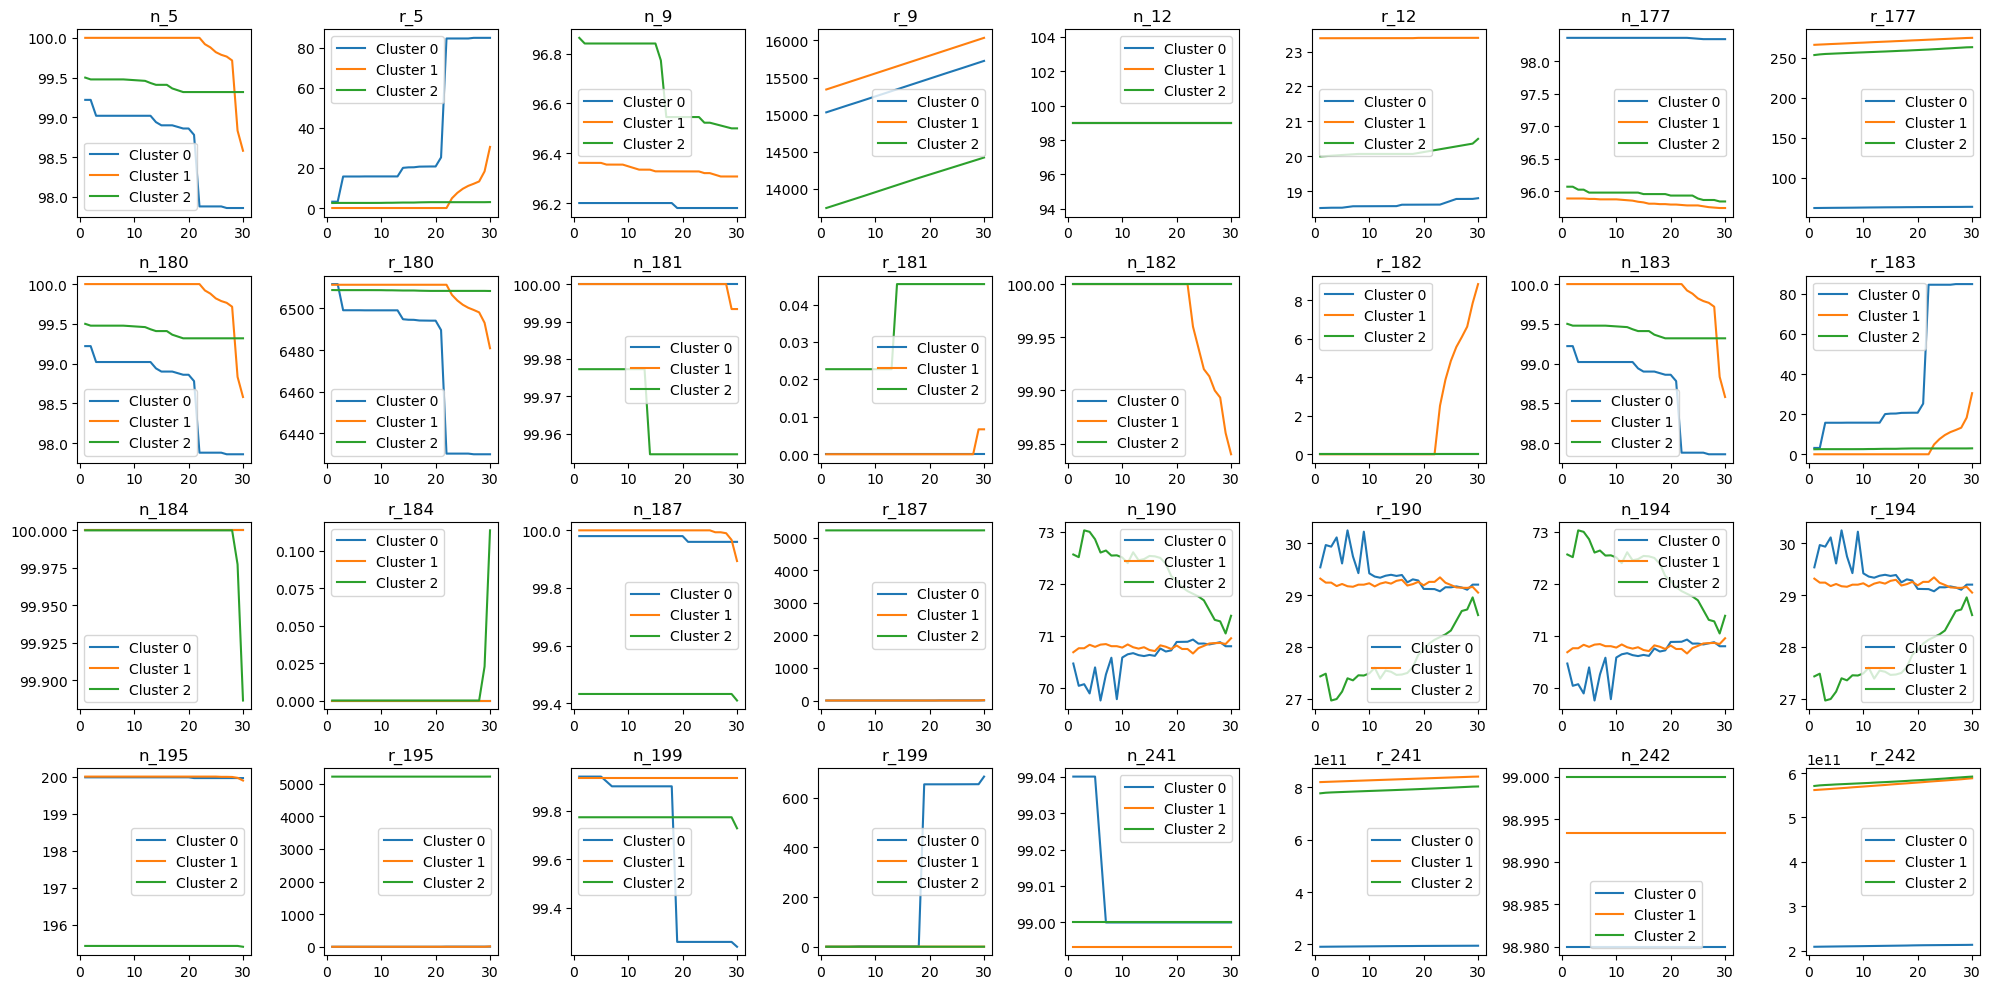

In [147]:
import matplotlib.pyplot as plt

# Assuming the dataframes are named 'cluster_0_mean_df', 'cluster_1_mean_df', 'cluster_2_mean_df', 'cluster_3_mean_df'
clusters = [cluster_0_mean_df, cluster_1_mean_df,cluster_2_mean_df]
cluster_names = ['Cluster 0', 'Cluster 1','Cluster 2']

# feature names list
feature_names = cluster_0_mean_df.columns.tolist()

# Create subplots with 4 rows and 8 columns, each cell will represent a feature
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))

# Reshape the axes array to 1D for easy iteration
axs = axs.ravel()

for i in range(len(feature_names)):
    for j in range(3):
        # Plot each cluster's line in the same subplot (feature)
        axs[i].plot(clusters[j].index + 1, clusters[j].iloc[:, i], label=cluster_names[j])
        
    axs[i].set_title(feature_names[i])
    axs[i].legend()

plt.tight_layout()
plt.show()

In [113]:
cluster_0_id = to_cluster_df[to_cluster_df['cluster']==0]['disk_id'].unique()
cluster_1_id = to_cluster_df[to_cluster_df['cluster']==1]['disk_id'].unique()
cluster_2_id = to_cluster_df[to_cluster_df['cluster']==2]['disk_id'].unique()

In [134]:
cluster_0_id

array([  470.,  1692.,  3686.,  3688.,  3692.,  3693.,  4102.,  4109.,
        5876.,  5883.,  7112.,  8149.,  8789., 12786., 17817., 17819.,
       19131., 19420., 19421., 22338., 22437., 22440., 22842., 23050.,
       23056., 24754., 24759., 25535., 25763., 28296., 29280., 29290.,
       36225., 37471., 37476., 37479., 38358., 38451., 38452., 38842.,
       39655., 39666., 42112., 42119., 42311., 42313., 42323., 42935.,
       44335., 44338.])

In [132]:
cluster_1_id

array([  531.,   601.,   609.,  1399.,  1408.,  1500.,  1870.,  1881.,
        2349.,  2530.,  2733.,  3167.,  3690.,  4885.,  5335.,  5349.,
        5351.,  5434.,  5563.,  5581.,  5753.,  5847.,  6920.,  7045.,
        7415.,  7981.,  8034.,  8036.,  8061.,  8197.,  8599.,  8605.,
        8844.,  9675.,  9758., 11140., 11952., 12360., 12583., 12613.,
       12755., 12781., 12818., 12825., 13498., 13564., 13579., 13686.,
       14208., 14877., 15078., 15274., 15284., 15466., 15473., 16067.,
       16306., 16480., 17435., 18452., 18461., 18796., 19450., 19460.,
       19988., 19992., 20005., 20022., 20114., 20324., 20920., 21058.,
       21275., 21593., 22229., 22336., 22439., 22568., 22599., 22602.,
       23253., 24027., 24395., 25063., 25231., 25271., 25624., 25759.,
       26706., 27250., 27664., 27720., 28019., 28040., 28174., 28179.,
       28302., 29461., 29467., 29470., 29917., 30026., 30557., 30644.,
       30646., 30827., 30836., 31133., 31295., 31304., 31570., 31804.,
      

In [117]:
cluster_2_id

array([  476.,  3720.,  4100.,  4105.,  5161.,  6314.,  8791.,  9437.,
        9452.,  9895., 11387., 11488., 15459., 18406., 19961., 21179.,
       22299., 23166., 23169., 23982., 23984., 24014., 24078., 25764.,
       25781., 30841., 34853., 35074., 35076., 35737., 36223., 36227.,
       36228., 36231., 36234., 36235., 36353., 37755., 38840., 38843.,
       40713., 40748., 42486., 42493.])

In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def plot_features(cluster_id, idx):
    sample_id = cluster_id[idx]
    sample_data = data[data['disk_id']==sample_id]

    # Dropping 'index' and 'label' columns
    features = sample_data.drop(['index', 'label'], axis=1).columns

    # Calculate the number of rows and columns for the subplots
    nrows = int(np.ceil(np.sqrt(len(features))))
    ncols = int(np.ceil(len(features) / nrows))

    # Create subplots with number of rows equivalent to number of features
    fig, axs = plt.subplots(nrows, ncols, figsize=(20, 20))  # Reduced figsize

    # Reshape the axes array to 1D for easy iteration
    axs = axs.ravel()

    # Sort the sample_data by time
    sample_data = sample_data.sort_values('index')

    # Convert 'index' column to datetime
    sample_data['index'] = pd.to_datetime(sample_data['index'], format='%Y%m%d')

    # Set 'index' as index
    sample_data.set_index('index', inplace=True)

    # label==1 data
    sample_data_label1 = sample_data[sample_data['label'] == 1]

    for j, column in enumerate(features):
        # Plot all data
        axs[j].plot(sample_data.index, sample_data[column], label='All data', color='blue')

        # Emphasize the data with label==1 by plotting them in red color
        axs[j].plot(sample_data_label1.index, sample_data_label1[column], color='red', linewidth=1, marker='o', markersize=3 ,label='Label 1')  # Reduced linewidth

        axs[j].set_title(f'{column} for disk_id {sample_id}')
        axs[j].set_ylabel(column)
        axs[j].legend()
    # Rotate x-axis labels
    for ax in axs:
        for label in ax.get_xticklabels():
            label.set_rotation(30)

    # Set x-axis label for the last row
    axs[-1].set_xlabel('Time')

    plt.tight_layout()
    plt.show()

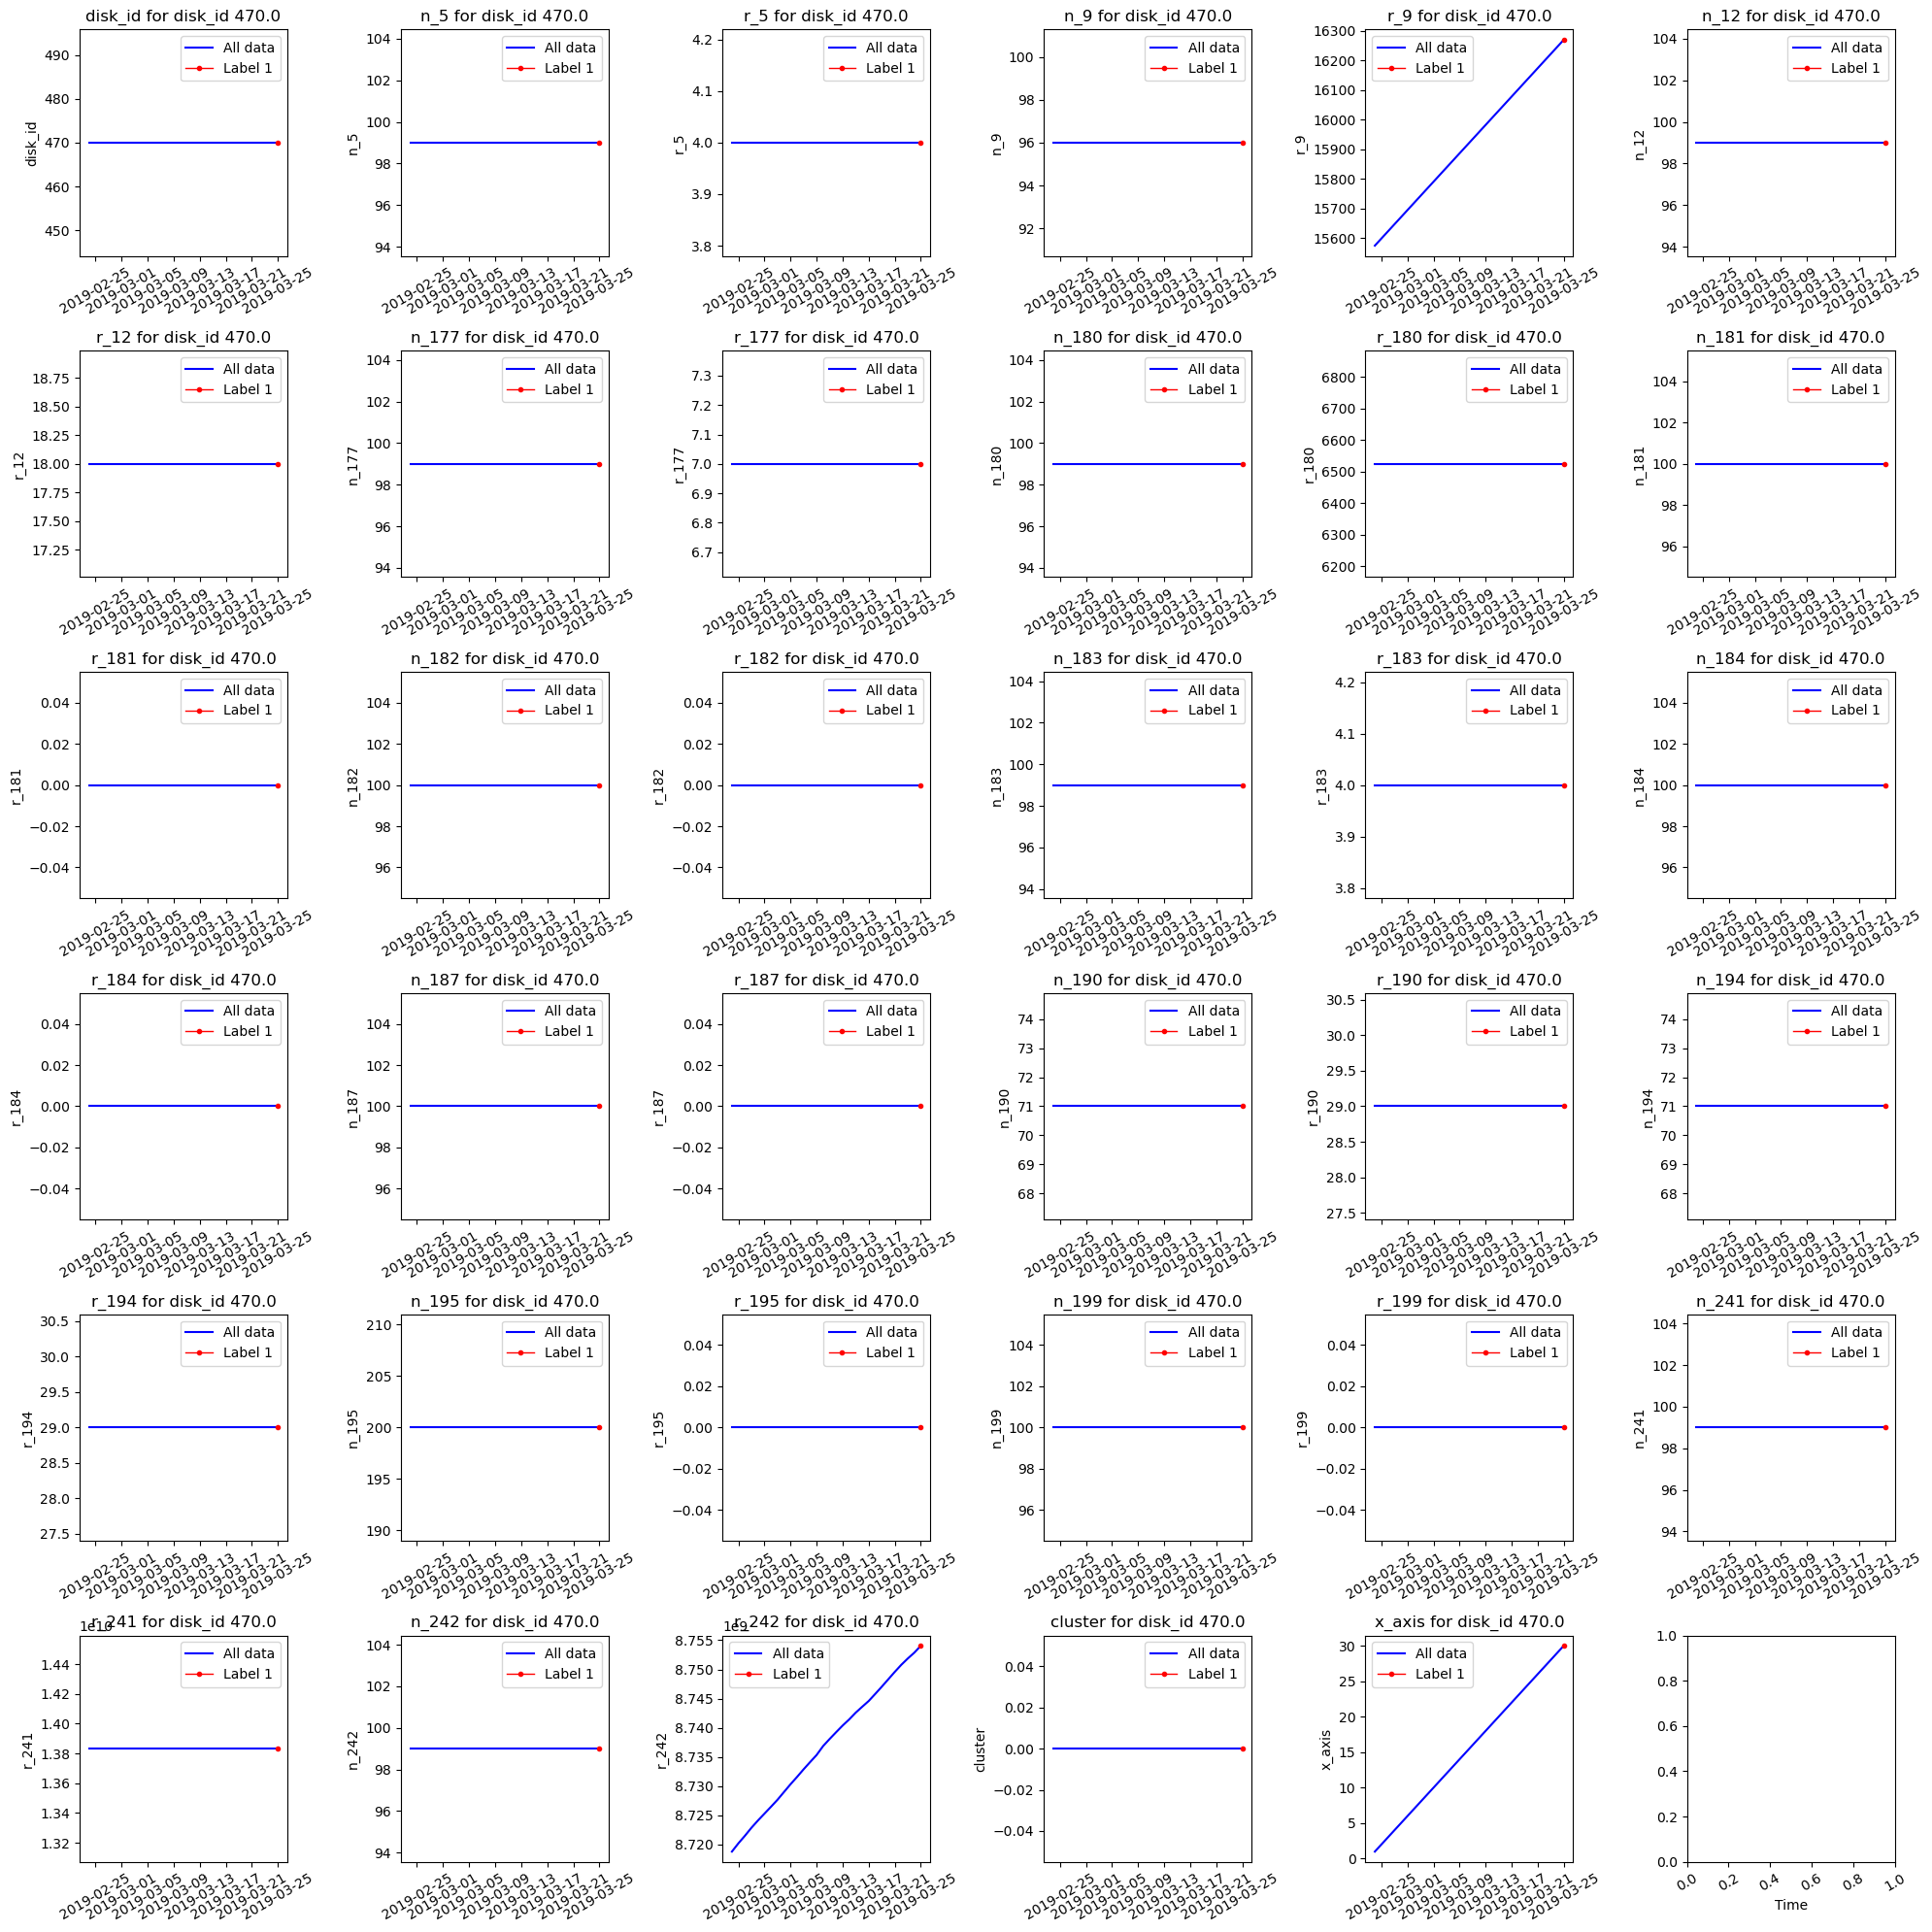

In [126]:
plot_features(cluster_0_id,0)

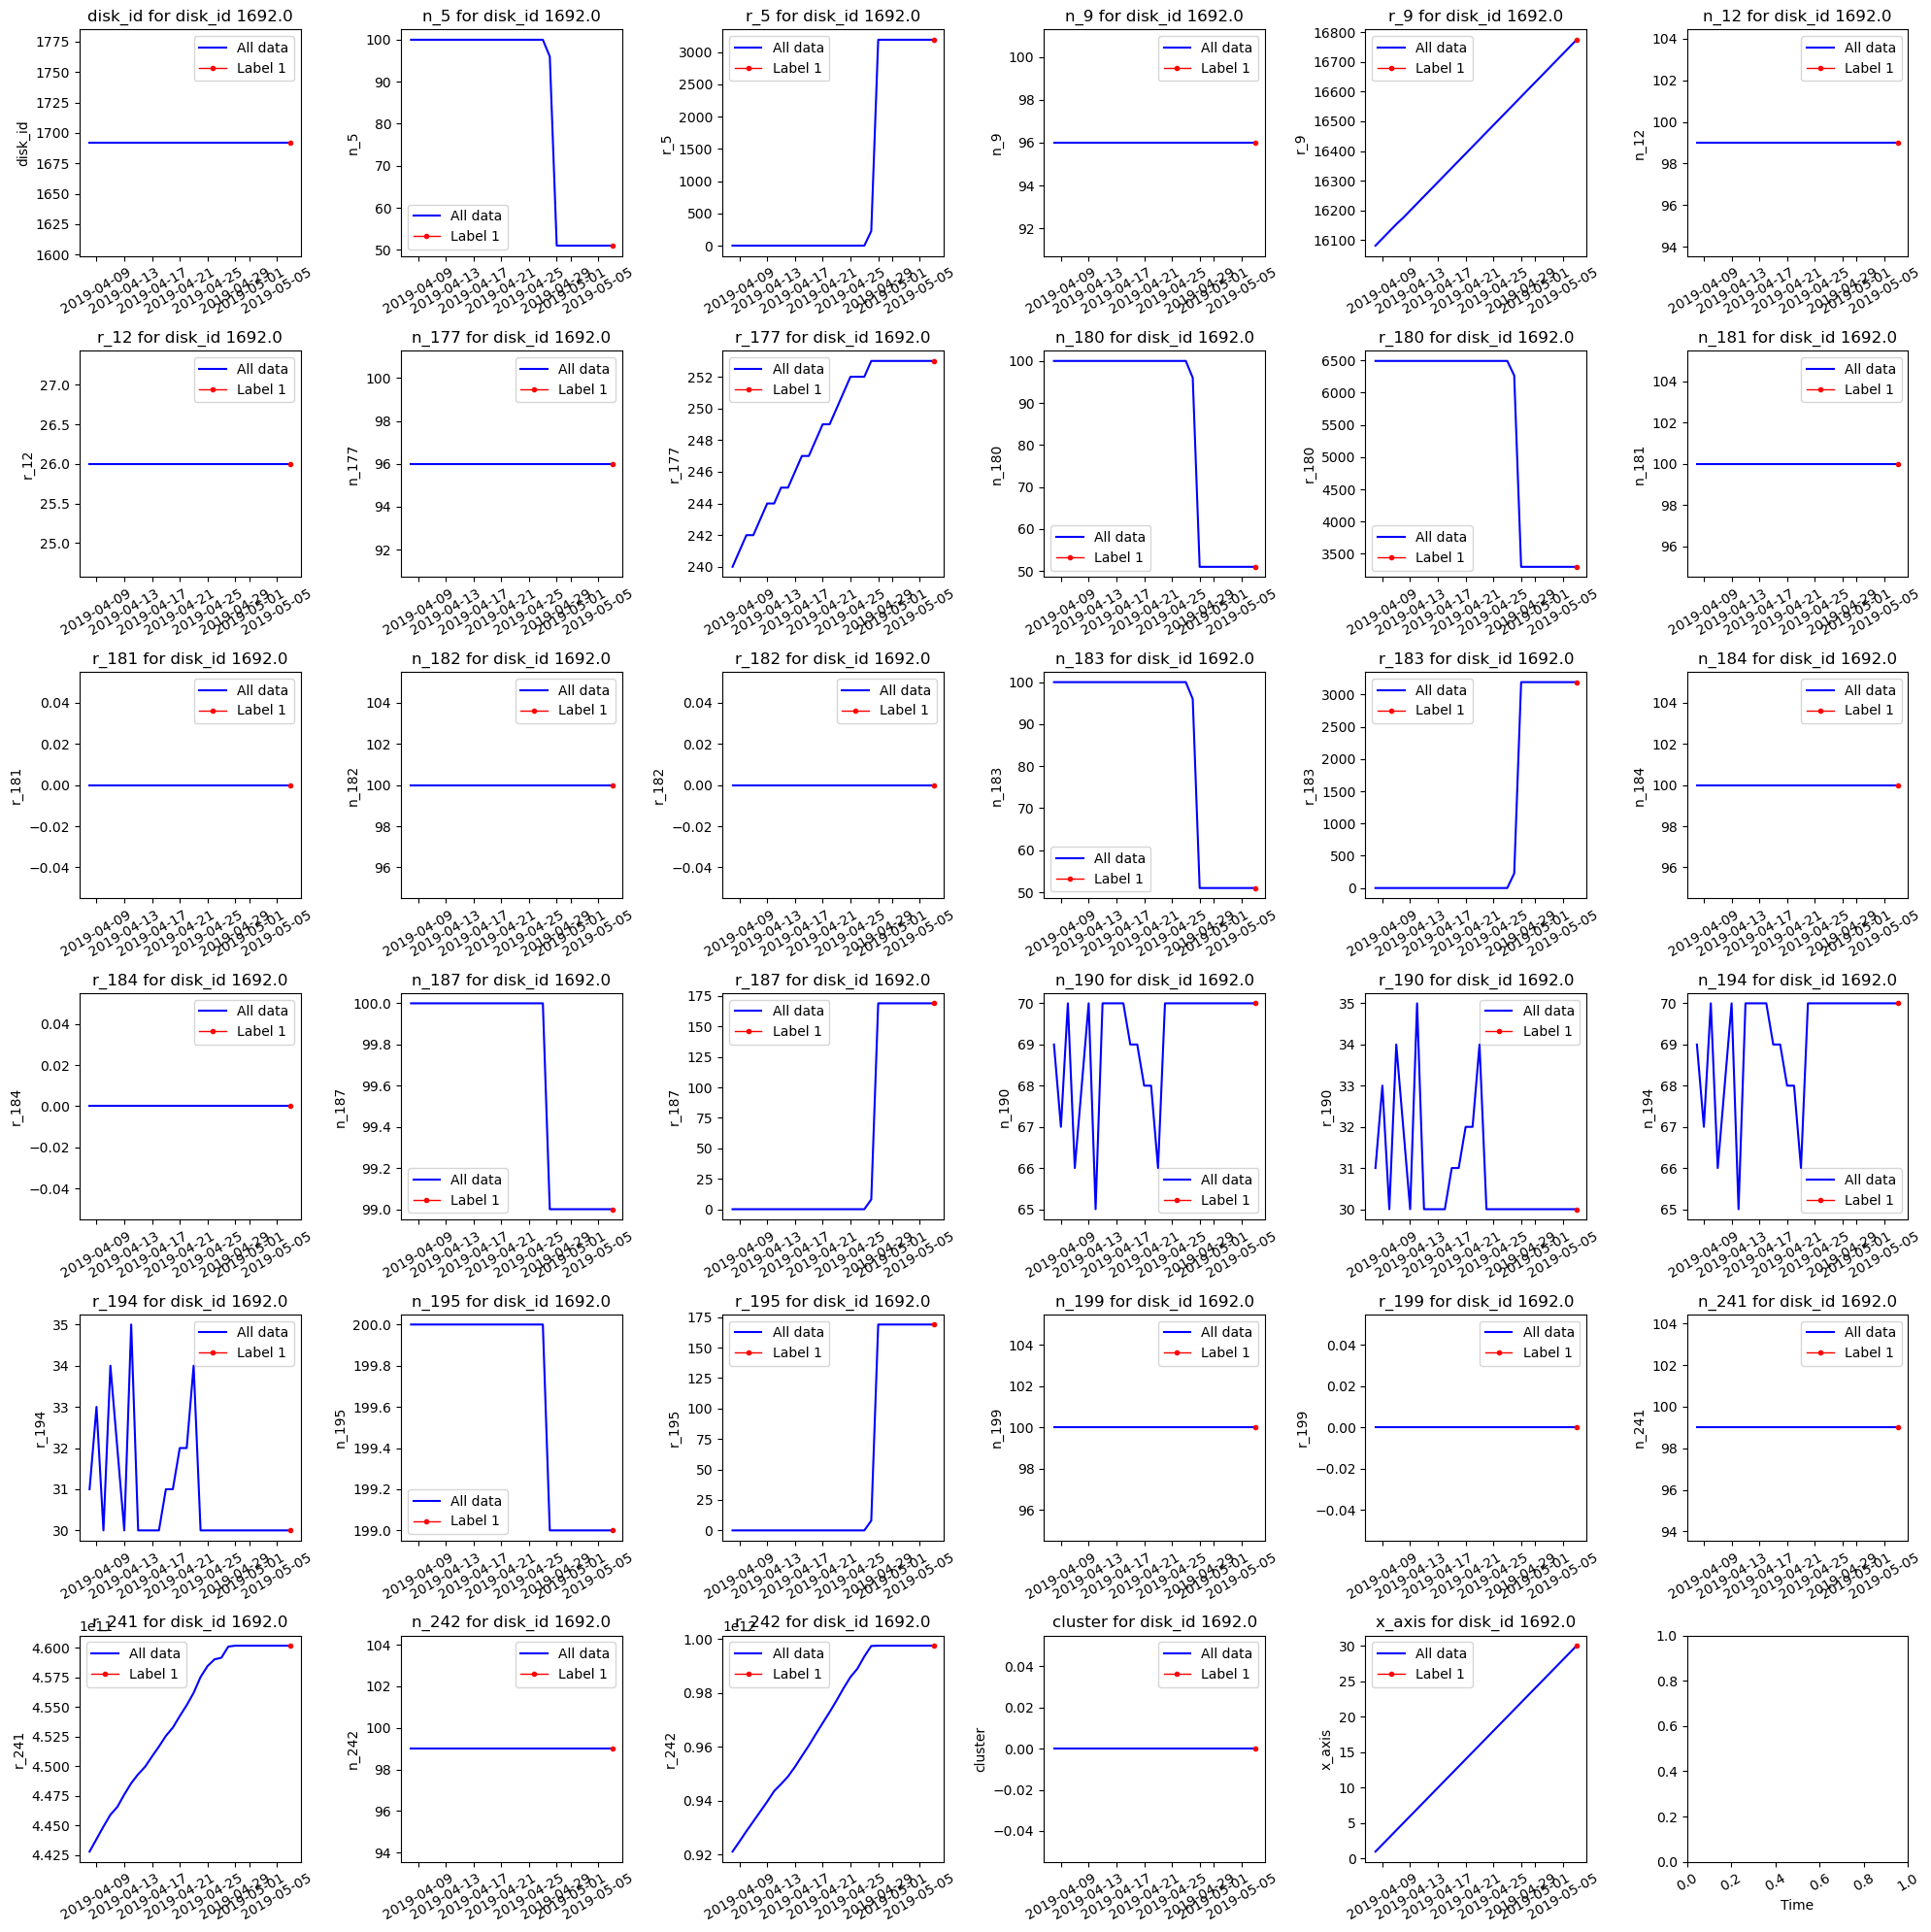

In [127]:
plot_features(cluster_0_id,1)

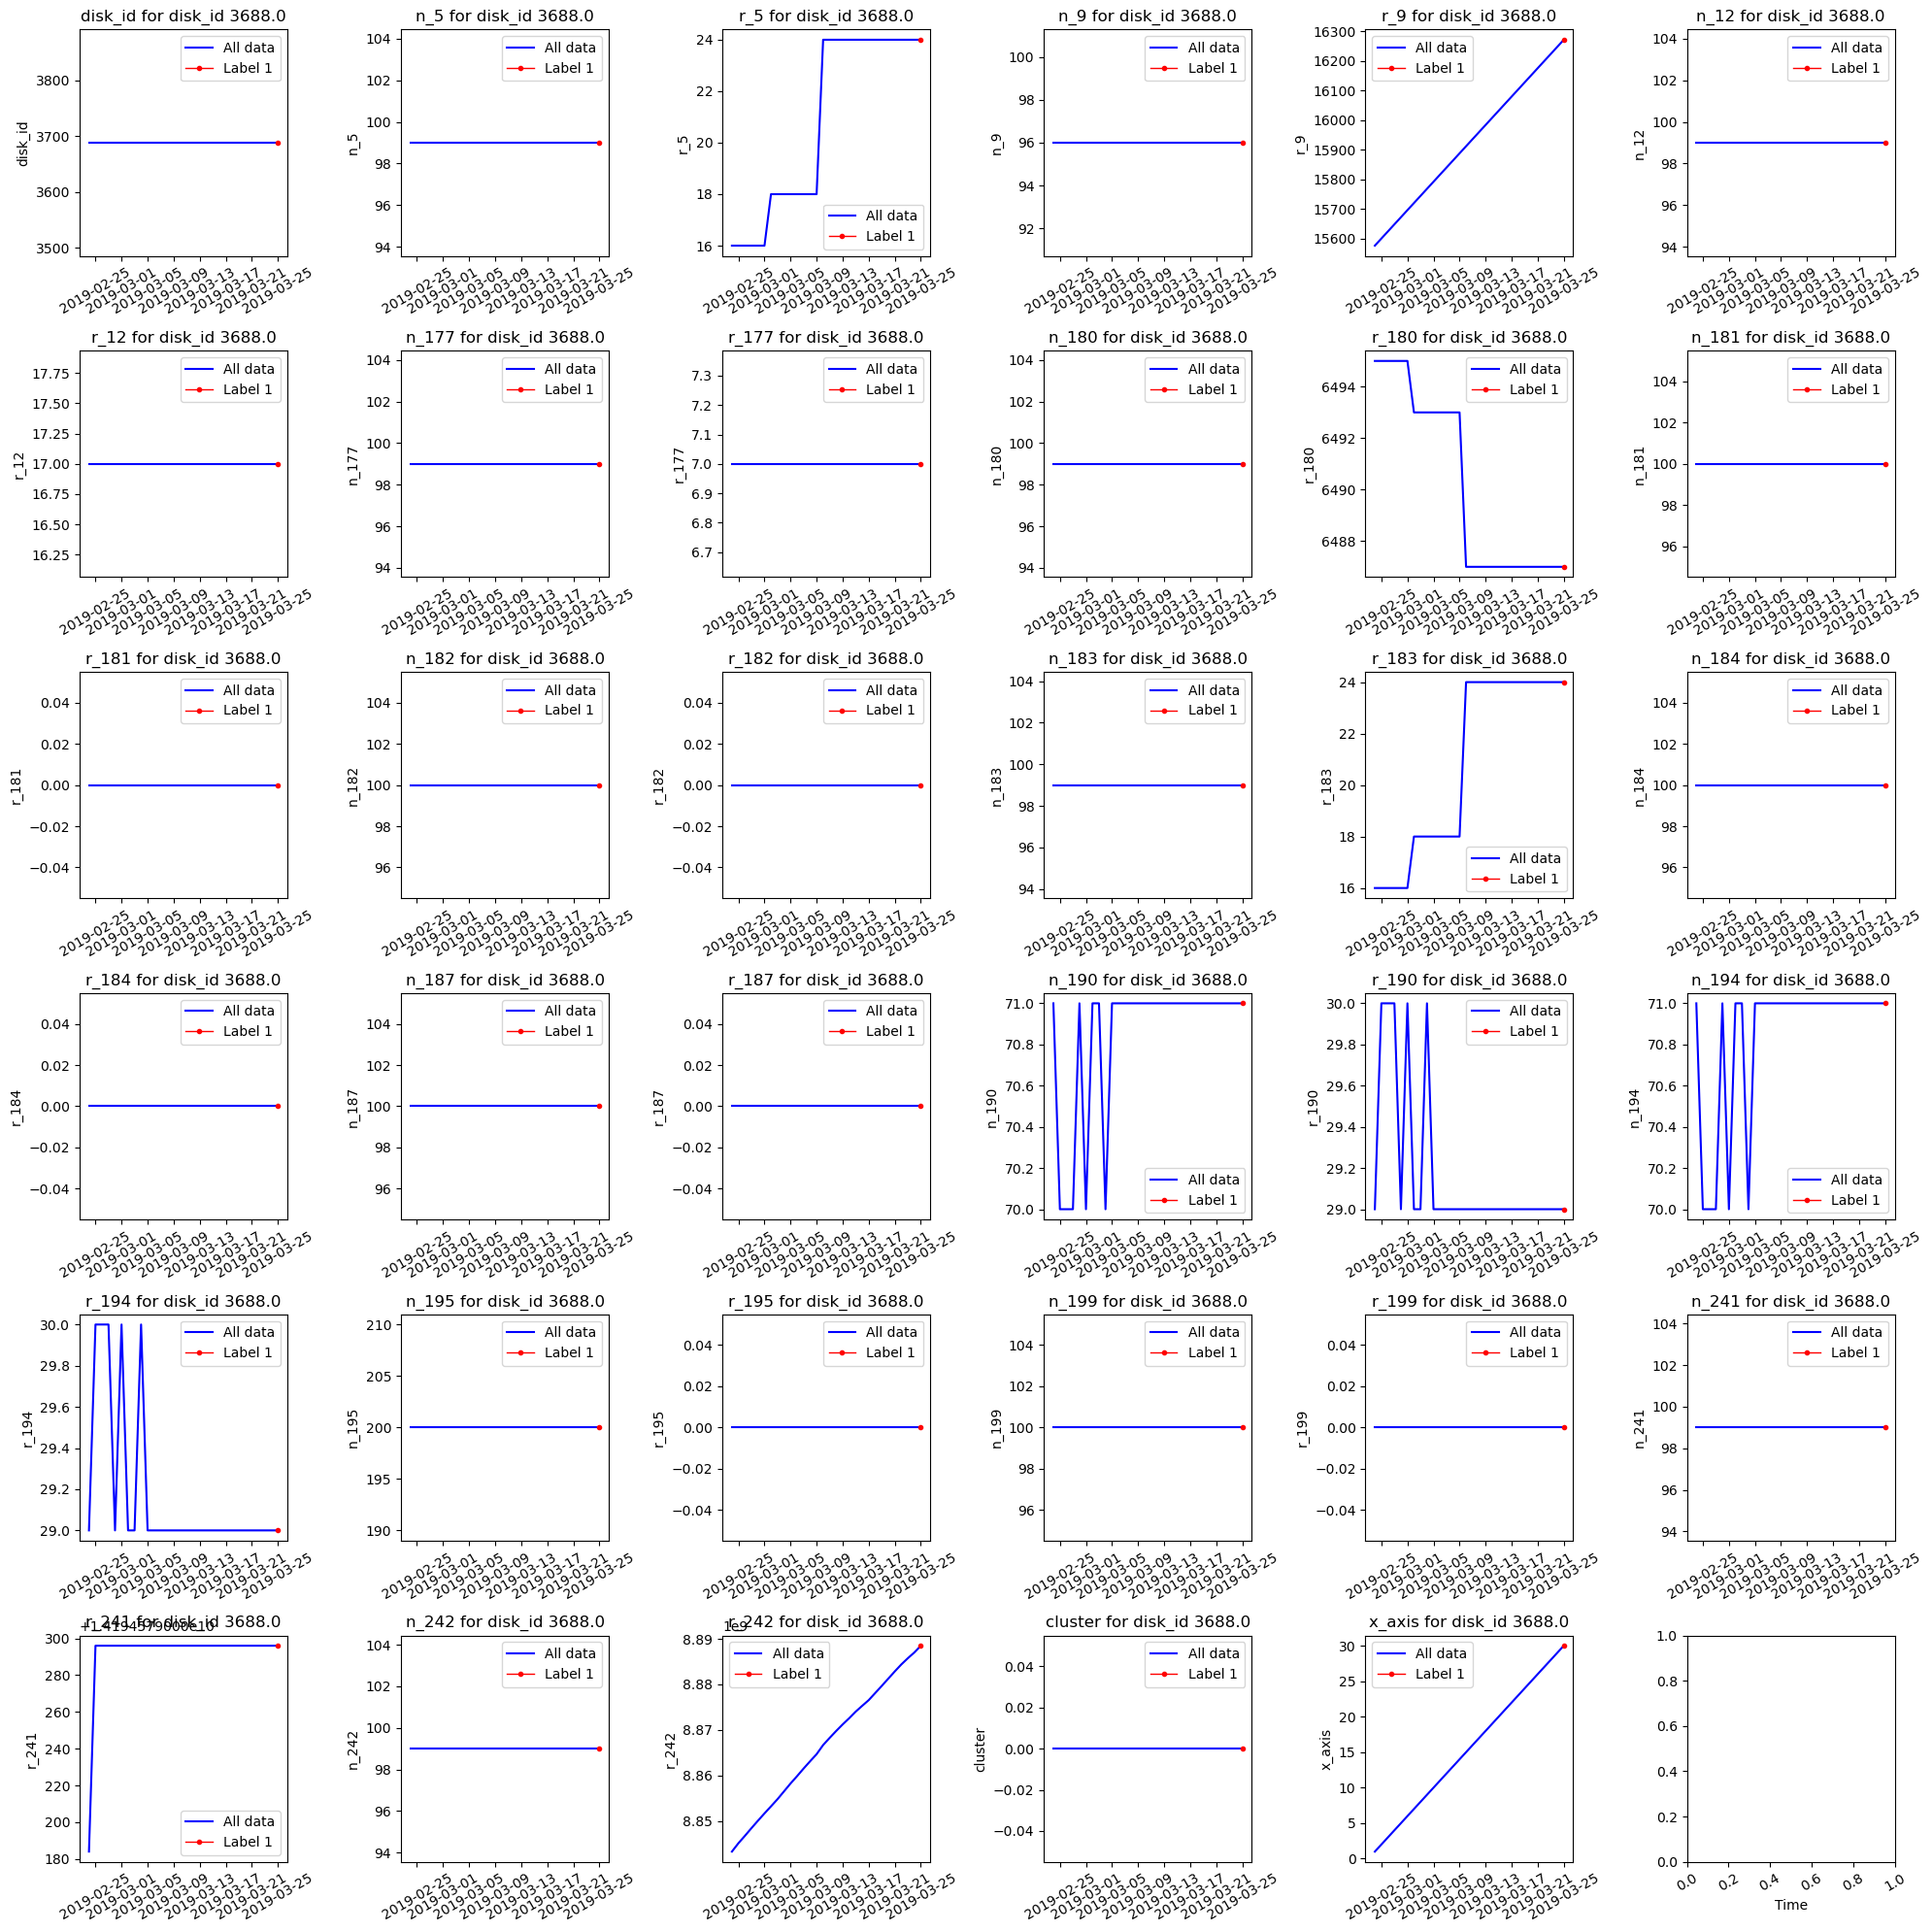

In [128]:
plot_features(cluster_0_id,3)

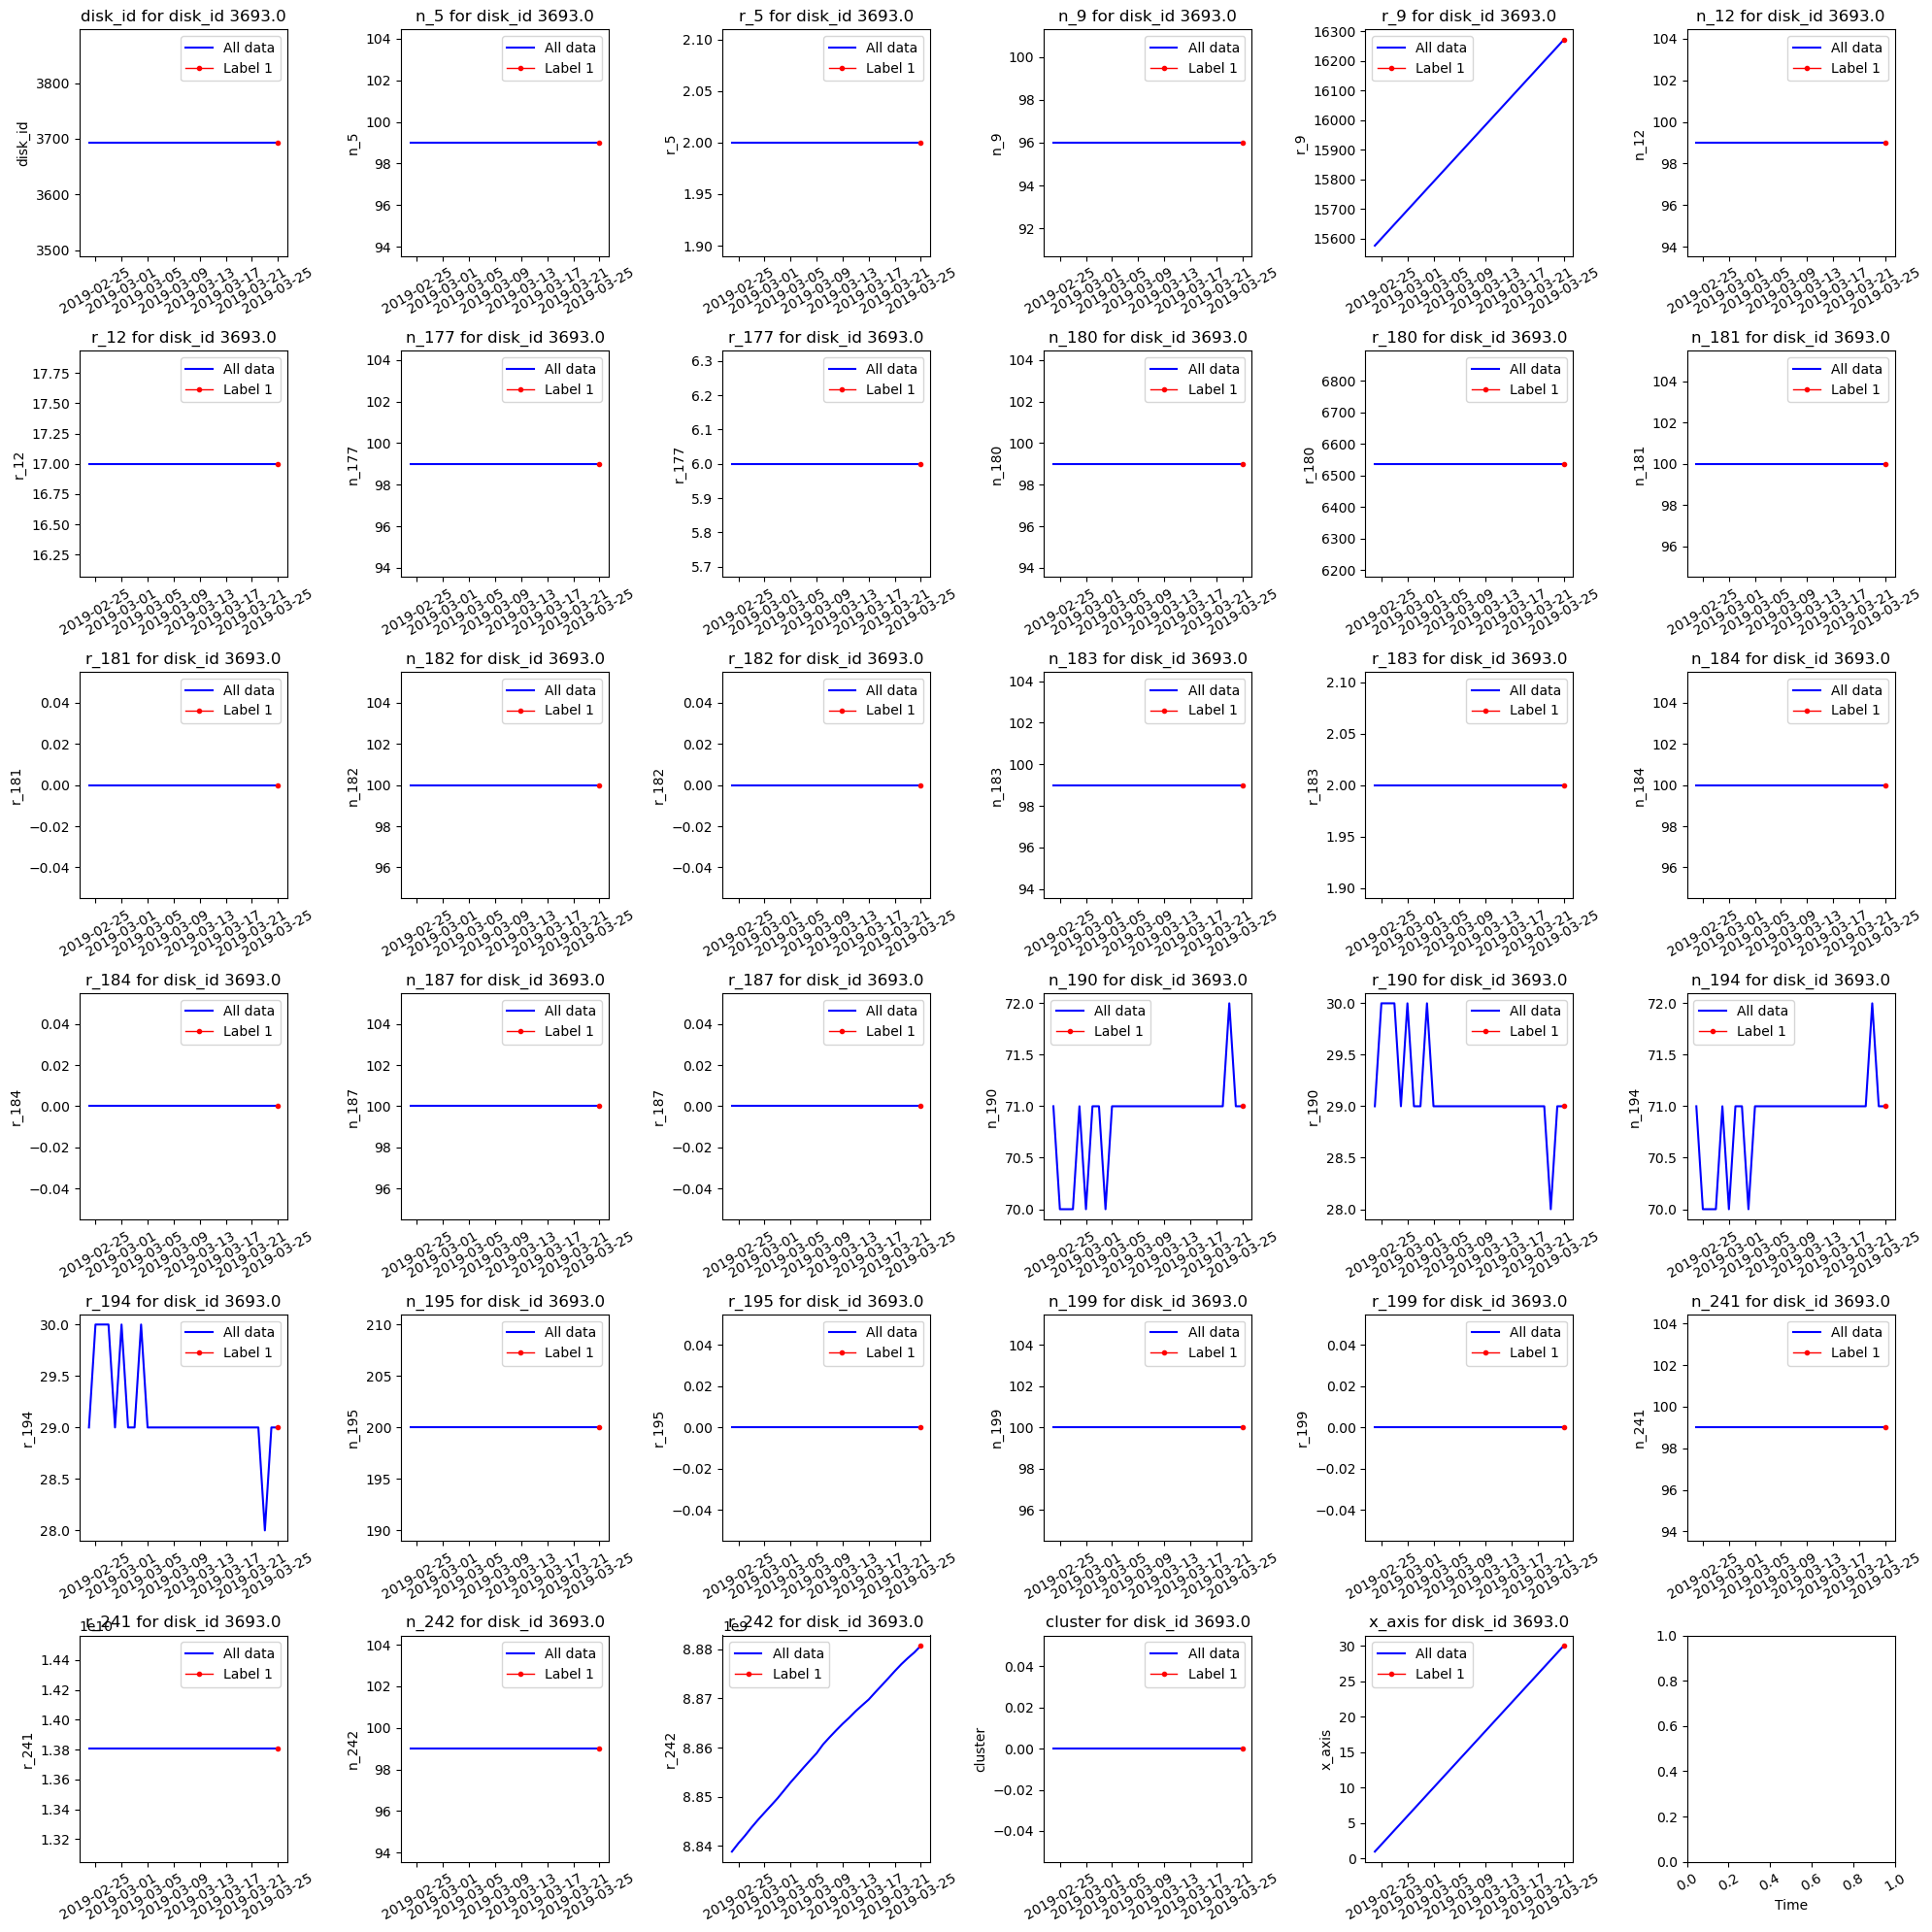

In [129]:
plot_features(cluster_0_id,5)